
<center style ="font-size: x-large; font-weight: 600; line-height: 1.1;padding: 10px">
WEST Tokamak Electron Density Profile Modeled with a Cubic Spline and Infered from Interferometry with Bayesian Inference</center>  
<center>
Daniel Jordan
</center>
 
### Abstract:
<div style="text-align: justify; padding: 20px"> 
insert abstract here
</div>

#### Key words: Nuclear Fusion, Tokamak, Interferometry, Bayesian Inference, Cubic Splines

## Introduction
### Interferometry
Interferometry is a diagnostic technique commonly used in nuclear fusion devices to gain information about the plasma. Lasers traverse the plasma. The electron density alters refractive index of the plasma. This slows down the laser and causes a phase shift. It can be shown that the phase shift is proportional to the line integrated electron density over the line of sight.

$$\Delta\phi = 2.82\times10^{-15} \lambda \int n_e dl$$

Where $\Delta\phi$ is the phase shift of the laser, $\lambda$ is the wavelength of the laser and $n_e$ is the electron density. Using the measured phase shift and laser wavelength, interferometry devices report data of the line integrated density.

$$\int n_e dl = \frac{\Delta\phi}{2.82\times10^{-15} \lambda}$$

In the [WEST](https://west.cea.fr/en/Phocea/Vie_des_labos/Ast/ast_service.php?id_unit=330) device there are many lasers used. They are fired from the outer wall of the tokamak and reflected back from the inner wall for a double pass of the plasma, see Figure 1.

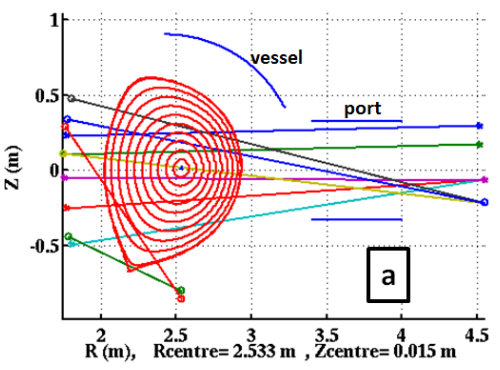
Figure 1: A diagram showing the cross section of the WEST tokamak. The red circles indicate magnetic flux surfaces. These are also surfaces of constant electron density. The colourd lines indicate the lines of sight of the interferometer lasers.

The electron density profile can be expressed in terms of the 2D axis $n_e(R,Z)$ or more elegantly in terms of $n_e(\rho)$. $R$ is the majour radial axis of the tokamak and Z the vertical axis. Where $n_e(\rho)$ is the electron density profile as a function of the normalised radious $\rho$. The electron density $(n_e)$ is known to be constant at magnetic flux surfaces, i.e. the red lines in figure 1. The normalised radious $\rho$ is 0 at the magnetic axis and 1 at the last closed magnetic flux surface. Every value of $\rho$ between corresponds to a different magnetic flux surface. Given infomation about the shape of the magnetic flux surfaces and $n_e(\rho)$ one can construct a complete plasma density profile, $n_e(R,Z)$. Thus the electron density profile is often expressed in one dimension along side the flux surfaces. Here is an example of a profile constructed with the NICE code at WEST and the corresponding flux surfaces.



In [5]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
from sampler_spline import sampler_spline_main
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


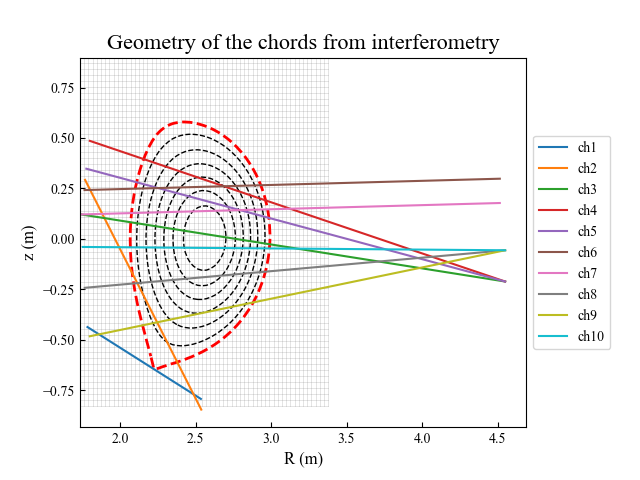

<IPython.core.display.Javascript object>


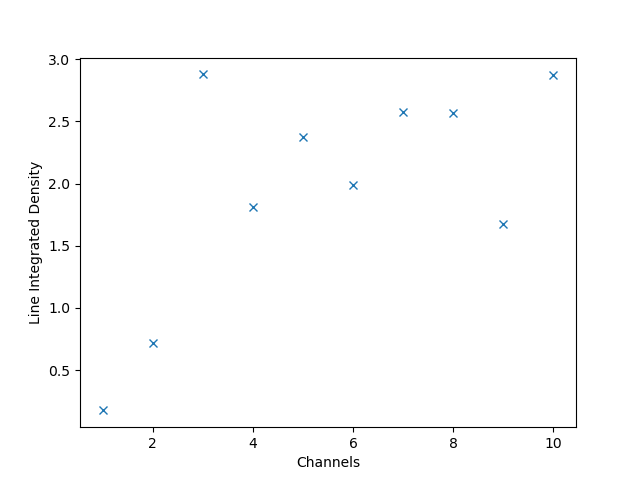

<IPython.core.display.Javascript object>


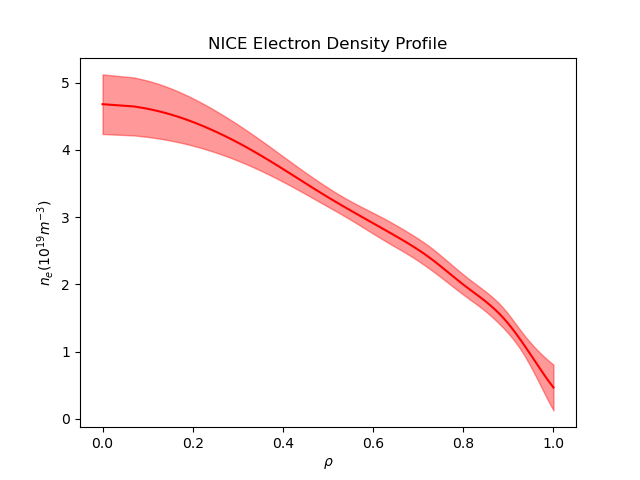

Text(0, 0.5, '$n_e (10^{19} m^{-3})$')

In [6]:
shot = 53259
t = 5.2113

geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}_occ1.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

figData = plt.figure()
plt.plot(interf.channels, interf.lid, 'x')
plt.xlabel('Channels')
plt.ylabel('Line Integrated Density')
plt.show()

#dens_prof.plot_density_profile()

figNICE = plt.figure()
plt.title('NICE Electron Density Profile')
nice_rho = dens_prof.rho_tor_norm_1d#np.linspace(0,1,101)
nice = dens_prof.dens_1d
nice_lower = dens_prof.dens_1d_lower
nice_upper = dens_prof.dens_1d_upper
plt.plot(nice_rho, nice, 'r')
plt.fill_between(nice_rho, nice_lower, nice_upper, color = (1,0,0,0.4), label='NICE 95% confidance interval')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$n_e (10^{19} m^{-3})$')

### Cubic Spline Function
This project uses a SciPy cubic spline to model the electron density profile, $n_e(\rho)$. The main paramaters for the function are a set of coordinates. SciPy then fits a cubic polynomial between each point ensuring the curvature matches up at each point to get an overall smooth function. It is also possible to specify the gradient at the edges of the spline. Below shows a SciPy cubic spline fit to a random set of points, where the gradient at the left is set to 0.

<IPython.core.display.Javascript object>


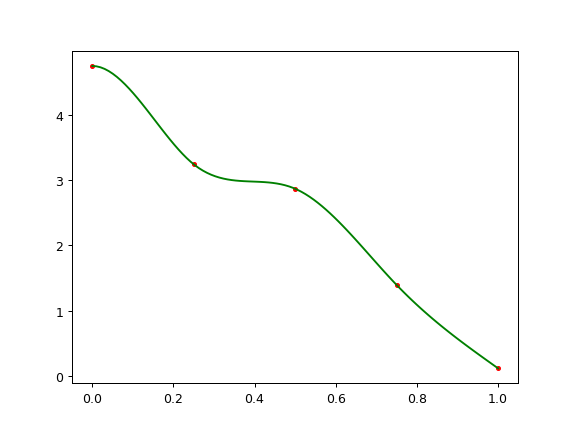

In [35]:
import numpy as np
randgen = np.random.default_rng(seed=49339389)
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

def parabolic(rho):
    a = 4
    return a*(1-rho**2)

x = np.linspace(0,1,5)
y = parabolic(x) + randgen.normal(0,0.5,5)
# y[-1]=0
spline = CubicSpline(x,y,bc_type=((1,0.0),(2,0.0)))

sx = np.linspace(0,1,100)
sy = spline(sx)
figSpline = plt.figure()
plt.plot(x,y, '.r',label='Origional Points')
plt.plot(sx,sy, '-g', label='Spline Fit')
plt.show()


The x-values of the points are commonly known as knots. In this project the y-values of the points shall be known as spline values. 

### Bayesian Inference
Bayes' theorem is a powerful tool that can assess the relative propability of something being true given there is a collection of data about it. In the terms of this interferometry project, it can be expressed as,

$$P[n_e(\rho)|\vec d, \sigma_{er}, \theta] = \frac{P[\vec d| n_e(\rho), \sigma_{er}] P[n_e(\rho)|\theta)]}{P[\vec d|\sigma_{er},\theta]}$$.


$$P[n_e(\rho)|\vec d, \sigma_{er}] = \frac{P[\vec d| n_e(\rho), \sigma_{er}] P[n_e(\rho)]}{P[\vec d|\sigma_{er}]}$$.

The posterior, $P[n_e(\rho)|\vec d]$ represents the relative probability a specific density profile $n_e(\rho)$ is the true profile given a set of data $\vec d$. The data $\vec d$, is what is measured by interferometry and is subject to an experimental error, $\sigma_{er}$. The posterior in general is not intuitive to know, but the likelihood is. The likelihood $P[\vec d|n_e(\rho)]$, is the probability of getting a set of data $\vec d$ given a specific electron density profile. It can be expanded to show how it is a product of each individual measurement $d_i$,

$$P[\vec d|n_e(\rho), \sigma_{er}] = \prod_{i}^{m}P[d_i|n_e(\rho), \sigma_{er}].$$

The likelihood is influenced by the experimental error. In this project we assume a gaussian error and so the likelihood is simply,

$$P[d_i|n_e(\rho)] = \mathcal{N}(d_i, mean=LID_i, sdv=\sigma_{er})$$.

To avoid precision errors it is more convenient to work with the log likelihood. When taking the log of the analytical form of each gaussian and summing them we get,

$$
\log \left(P[\vec d|n_e(\rho), \sigma_{er}]\right) = m \times \log\left(\frac{1}{\sigma_{er}\sqrt{2\pi}}\right) + \sum_{i=1}^{m} -\frac{1}{2} \frac{(d_i - LID_i)^2}{\sigma_{er}^2} 
$$

The $LID_i$ is the Line Integrated Desnsity that would be measured by an error free version of the interferometry device given the density profile $n_e(\rho)$ is the ground truth. $LID_{n_e(\rho)}$ can be computed with the forward model which is a small simulation of an error free version of the WEST interferometry device. More on this later.

$P[\vec d]$ is the probability of data $\vec d$, and serves as a normalisation factor. It is ignored in this study as the shape of the posterior is the only factor that deterimes the most likely electron density profile.

$P[n_e(\rho)]$ is known as the prior distribution. It represents all knowledge of the plasma density profile before the experiment. This is in the form of assumed knowledge of the spline parameters. The exact distributions selected is different for my implimentations and will be explained later. 

The log posterior for a set of parameters and hyperparameters can be obtained by summing the log prior and log likelihood.

One method to perform the inference is to find the spline parameters that maxemise the posterior. This project uses a differential evolution algorythem from SciPy. Differential evolution is a population-based metaheuristic search algorithm that operates by improving a population of candidate solutions. The solutions are evaluated by the size of the posterior they lead to. It does not use the gradient, which means it is not sensitive to noisy functions. It is simple to implement and can efficiently explore large and complex search spaces. Although it can require a large number of function evaluations to reach the optimal solution and isn't suitable for for high-dimensional problems. It is inspired by evolution. It creates new solutions by adding the difference between two randomly chosen solutions to another randomly chosen solution. This is called the mutation operation. Then, it mixes some elements of the mutated solution with some elements of the original solution. This is called the crossover operation. The new solution is then compared with the original solution and the better one is kept. This is called the selection operation.  
  
Maxemising the posterior is great but it does not provide a degree of uncertinty. For this we turn to MCMC sampling. This project uses the python emcee package and its Ensemble Sampler. This algorithm runs multiple parallel chains (called walkers) and proposes new states for each walker by using the current states of the other walkers. States are accepted or rejected with the matropolis hasting criterion. If the walkers are initialised completly randomly then they can take some time before they begin to find the maximum of the posterior and sample from there more often than its edges. This means the initial samples often dont well reflect the posterior distribution. For this reason some initial number of samples are rejected. This is called the burn in. Although to decrese the amount of burn in required we can initialise the walkers to be a small random distance from the posterior maximum, which we know form deploying the differential evolution algorythem. After we have many samples of cubic spline parameters that reflect the posterior distribution we can convert them into profiles using the cubic spline function. The average of these profiles at each rho is an indication of the posterior maximum, and the 2.5% and 97.5% quantiles can be computed to give the 95% confidance interval and thus an idea on uncertainty.

In [103]:
from dask.distributed import Client
nworkers = 14
client = Client(n_workers=nworkers)
import dask


/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33283 instead
  warnings.warn(


In [104]:
client

<Client: 'tcp://127.0.0.1:41359' processes=14 threads=28, memory=3.82 GiB>

In [10]:
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
import numpy as np
from scipy.stats import multivariate_normal as mvn
import emcee
import time
from scipy import stats
from tqdm import tqdm
import optuna

/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# First Attempt 

The knot positions and spline values are free to move and have uniform priors. Except the core and edge knots positions are fixed, also the edge spline value $esv$ has a gaussian prior. The core gradient value $cgv$ also has a gaussian prior. The full prior is a product of the various distributions, 

$$
P[n_e(\rho)] = \mathcal{N}(esv, mean=0, \sigma_{esv}) \times \mathcal{N}(cgv, mean=0, \sigma_{cgv}) \times (1^{-1})^{NKNOTS-2} \times (2 NICEmax)^{-1},
$$

where since 2 of the knots are already assigned to the core and edge there is NKNOTS-2 uniform priors for the knot positions. $2 NICEmax$ is around 10. Although the uniform priors take effect by simply restricting the values of the parameters within their bounds. They don't affect the shape of the posterior within these bounds and their constant values don't need to be multiplied in.  
  
Similiar to the likelihood using the logarithym helps avoid precision issues and then the prior is,  
  
$$
\log\left(P[n_e(\rho)]\right) = \log\left(\frac{1}{\sigma_{esv}\sqrt{2\pi}}\right) -\frac{1}{2}\frac{(esv)^2}{\sigma_{esv}^2} + \log\left(\frac{1}{\sigma_{cgv}\sqrt{2\pi}}\right) -\frac{1}{2}\frac{(cgv)^2}{\sigma_{esv}^2}
$$

also here the constants don't need to be included in the computation as they don't affect the shape of the posterior. 

The various parameters and their values/distributions are listed below.

Constants:
Interferometry Data, line integrated density of lasers, $\vec d$  
Edge Knot Location at $\rho=1$  
Core Knot Location at $\rho=0$  

Hyperparameters:     
Number of MCMC Burn Samples, NBURN = 500  
Number of MCMC Sample, NSAMPLES = 4000  
Number of MCMC Walkers = 2 $\times$ number of cubic spline parameters $= 2 \times 19 = 38$  
Number of Knots, NKNOTS = 10  
Experimental Error, $\sigma_{er}$ = 0.03 (as reported by WEST)   
Standard Deviation of Edge Spline Value, $\sigma_{esv}$ = 0.1   
Standard Deviation of Core Gradient Value, $\sigma_{cgv}$ = 0.1   
Bounds of Knot Locations uniform prior [0,1]  
Bounds of Spline Values uniform prior [0,10]

Cubic Spline Parameters:  
Knot Locations, uniform prior  
Spline Values (except edge), uniform prior  
Edge Spline Value, Gaussian prior  
Core Spline Gradient, Gaussian prior.  

Hyper Parameters Are:
{'NKNOTS': 5, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1}
Computing MAP
Results of MAP


 message: Optimization terminated successfully.
 success: True
     fun: 89.63788019053254
       x: [-2.071e-02 -1.743e-02  4.234e+00  2.051e+00  2.587e+00
            2.241e+00  6.088e-01  5.162e-01  6.247e-01]
     nit: 225
    nfev: 30540


<IPython.core.display.Javascript object>


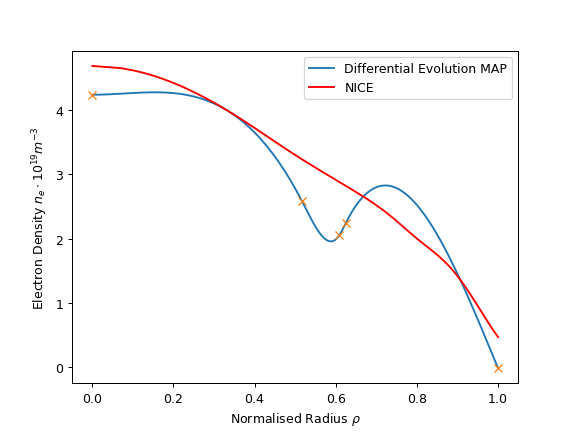

In [38]:
NBURN = 500
NSAMPLES = 4000

# Hyperparamters
NKNOTS = 5
SIGer = 0.03
SIGesv = 0.1
SIGcgv = 0.1

#might not be necessary any more since no uniform dist are used
BOUNDS = [(-5*SIGcgv,5*SIGcgv),(-5*SIGesv,5*SIGesv)]+[(0,10) for i in range(NKNOTS-1)] + [(0,1) for i in range(NKNOTS-2)]
RHO = dens_prof.rho_tor_norm_1d #equilivant of np.linspace(0,1,101) 
rho_1000 = np.linspace(0,1,1000)
#geo is line geometry, equi are the fulxsurfaces equilibrium
R = compute_response_matrix(geo, equi, RHO)
d = interf.lid

hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv}
hyperbounds = {"NKNOTS":(3,40),"SIGer":(0,0.5),"SIGesv":(0,0.5),"SIGcgv":(0,0.5)}

class PosterioR:
    def __init__(self, hyperbounds, bounds, rho, R, d, nburn, nsamples):
        self.hyperbounds = hyperbounds
        self.bounds = bounds
        self.rho = rho
        self.R = R
        self.d = d
        self.nburn = nburn
        self.nsamples = nsamples
        self.params_map = None

    def Profile(self, params, rho, hyperparameters):
        cgv, esv = params[0:2]
        spline_values = params[2:NKNOTS+1]
        knot_locations = params[NKNOTS+1:]
        all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
        all_spline_values = np.block([spline_values,esv])
        #ensure unique to avoid error, x must be increasing
        if len(np.unique(all_knots))<len(all_knots):
            all_knots = all_knots + np.linspace(0,0.000001,len(all_knots))
        sort = np.argsort(all_knots)
        cubic_spline = CubicSpline(all_knots[sort], all_spline_values[sort], bc_type=((1,cgv),(2,0)))
        n_e = cubic_spline(rho)
        return n_e
    def Plot_profile(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        fig_prof = plt.figure()
        plt.plot(self.rho, n_e)
        plt.xlabel(r'Normalised Radius $\rho$')
        plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$')   
        plt.show()
    
    def Log_prior(self, params, hyperparameters):
            #check bounds
        within_bounds = True
        for i in range(len(params)):
            within_bounds = within_bounds and params[i] > self.bounds[i][0] and params[i] < self.bounds[i][1]
        if not within_bounds:
            return -np.inf    
        cgv, esv = params[0:2]
#         spline_values = params[2:NKNOTS+1]
#         knot_locations = params[NKNOTS+1:]
#         all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
#         all_spline_values = np.block([spline_values,esv])
        return -(esv**2 / hyperparameters['SIGesv']**2) - (cgv**2 /  hyperparameters['SIGcgv']**2)

    def Log_likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        LID = R @ n_e
        return np.sum(-(self.d - LID)**2 / hyperparameters['SIGer']**2)

    def Log_posterior(self, params, NKNOTS,SIGer,SIGesv,SIGcgv):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return -np.inf
        else:
            return log_prior + self.Log_likelihood(params, hyperparameters)
    
    def Neg_log_posterior(self, params, NKNOTS,SIGer,SIGesv,SIGcgv):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return +np.inf
        else:
            return -(log_prior + self.Log_likelihood(params, hyperparameters))
    
    def ComputeMAP(self, hyperparameters, verbose=False):
        print('Computing MAP')
        results = differential_evolution(self.Neg_log_posterior, self.bounds, workers=nworkers, args=tuple(hyperparameters.values()), maxiter=5000)
        self.params_map = results.x
        if verbose:
            print('Results of MAP\n\n')
            print(results)            
            rho_1000 = np.linspace(0,1,1000)
            params_map=results.x
            cgv, esv = params_map[0:2]
            spline_values = params_map[2:NKNOTS+1]
            knot_locations = params_map[NKNOTS+1:]
            all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
            all_spline_values = np.block([spline_values,esv])
            figDifEv = plt.figure()
            plt.plot(rho_1000,self.Profile(results.x, rho_1000, hyperparameters),label='Differential Evolution MAP')
            plt.plot(RHO,nice, 'r', label='NICE')
            plt.plot(all_knots,all_spline_values,'x')
            plt.xlabel(r'Normalised Radius $\rho$')
            plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$')  
            plt.legend()
            plt.show()
        return self.params_map
    
    def MCMCsampling(self, hyperparameters, recompute_map=False):
        print('Performing MCMC Sampling of Posterior')
        ndim = len(self.bounds)
        nwalkers = ndim * 2
        if recompute_map:
            self.params_map = self.ComputeMAP(hyperparameters)
        params_start = self.params_map + randgen.uniform(0,0.01,(nwalkers, ndim))
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.Log_posterior, kwargs=(hyperparameters))
        print("MCMC sampling starts")
        time1 = time.time()
        print("Burn-in")
        state = sampler.run_mcmc(params_start, self.nburn, progress=True)
        sampler.reset()
        print('Sampling')
        sampler.run_mcmc(state, self.nsamples, progress=True, skip_initial_state_check=False)
        time2 = time.time()
        samples = sampler.get_chain(flat=True)
        print(f'Sampling finished. Time Taken: {time2 - time1} s')
        return samples
    
    def Likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        li = mvn(mean=self.R @ n_e, cov=np.diag(np.repeat(hyperparameters['SIGer'],len(d))))
        return li.pdf(self.d)
    
    def Log_marginal_likelihood(self, samples, hyperparameters):
        #maximizing the marginal likelihood is usefull for paramater optimisation
        #It will be estimates with Harmonic Mean Estimator, 
        #this is the inverse average of the likelihood with posterior samples 
        samples_7split = [samples[a:a+int(samples.shape[0]/nworkers),:] for a in range(nworkers)]
        print('Computing Likelihoods:')
        @dask.delayed
        def li_batch_compute(samples):      
            li = self.Likelihood(samples[0], hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                li = np.block([li, self.Likelihood(samples[i,:],hyperparameters)])
            return li
    
        li_batches = []
        for samples_batch in samples_7split:
            li_batches.append(li_batch_compute(samples_batch))

        li_batches = dask.compute(*li_batches)
        log_marginal_likelihood = -np.log(len(samples) + np.log(np.sum([np.sum(1/li) for li in li_batches])))
        return log_marginal_likelihood
                                          
    def Neglogmargeli(self, hyperparameters):#NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
#             print('Trial Value',hyper_value)
#         hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        samples = self.MCMCsampling(hyperparameters, recompute_map=True)
        return -self.Log_marginal_likelihood(samples, hyperparameters)
      
    def Optimise_hyper(self, hyper, hyperparameters, study_name, verbose=False):
        print('\n\nOptimising the hyperparameter:',hyper)
        
        def objective(trial):
            hyper_value = trial.suggest_float(hyper, self.hyperbounds[hyper][0], self.hyperbounds[hyper][1])
            hyperparameters[hyper] = hyper_value
            return self.Neglogmargeli(hyperparameters)
        storage_name = "sqlite:///{}.db".format(study_name)
        study = optuna.create_study(study_name=study_name, storage=storage_name)
        study.optimize(objective, n_trials=100)
  # E.g. {'x': 2.002108042}

        if verbose:
            print('Results of Optimise for ',hyper,' are:', study.best_params[hyper])
        hyperparameters[hyper] = study.best_params[hyper]
        return hyperparameters
        
    def Plot_posterior(self, hyperparameters):
        time_s = time.time()
        @dask.delayed
        def samples2profiles(samples):
            profiles = self.Profile(samples[0,:], self.rho, hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                profiles = np.block([[profiles],
                                     [self.Profile(samples[i,:], self.rho, hyperparameters)]])
            return profiles
        
        samples = self.MCMCsampling(hyperparameters)
        samples_7 = [samples[a:a+int(samples.shape[0]/7),:] for a in range(7)]
        print('Converting the Samples to Profiles')
        profiles_batches = []
        for samples_batch in samples_7:
            profiles_batches.append(samples2profiles(samples_batch))
        profiles_batches = dask.compute(*profiles_batches)
        profiles = profiles_batches[0]
        for i in range(1,len(profiles_batches)):
            profiles = np.block([[profiles],
                                 [profiles_batches[i]]])
        print('Time Taken:', time.time() - time_s,'s')
        
        print('Computing the mean and 95% confidance intervals')
        
        profiles_mean = profiles.mean(axis=0)
        profiles_median = np.median(profiles, axis=0)
        profiles_mode = stats.mode(profiles, axis=0, keepdims=False).mode.flatten()
        profiles_lower = np.percentile(profiles, 2.5, axis=0)
        profiles_upper = np.percentile(profiles, 97.5, axis=0)
        figMCMC = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.fill_between(self.rho, profiles_lower, profiles_upper,color = (0,1,0,0.4),label='95% confidance interval')
        plt.plot(nice_rho, nice, 'r', label='NICE')
        plt.fill_between(nice_rho, nice_lower, nice_upper, color = (1,0,0,0.4), label='NICE 95% confidance interval')
        plt.legend()
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        figMedain = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.plot(nice_rho,nice, 'r', label='NICE')  
        plt.plot(self.rho, self.Profile(self.params_map, self.rho, hyperparameters),label='MAP')
        plt.legend()
        plt.xlabel(r'Normalised Radius $\rho$')
        plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$') 
        plt.show()
        return {'mean':profiles_mean,'median':profiles_median,'mode':profiles_mode,'lower':profiles_lower,'upper':profiles_upper}
         
        
post = PosterioR(hyperbounds, BOUNDS, RHO, R, d, NBURN, NSAMPLES)
print('Hyper Parameters Are:')
print(hyperparameters)
post.ComputeMAP(hyperparameters, verbose=True)
# profile_averages = post.Plot_posterior(hyperparameters)
a=1                           

# Incorperating Smoothness

Looking at the differential evolution MAP we see how eradicly the inference places the spline values. We don't expect the electron density to be able to change so dramatically within the plasma and so there is some prior knowledge of smoothness that can be incorperated.

To incorperate smoothness I will use a multivariate gaussian with a stationary kernel as the prior for the spline values. Scipy.stats has a method for generating defining this multivariate Gaussian and computing its log_pdf value for an input set of cubic spline values $\vec{sv}$. This can be added to the previous log prior to combine them. It can be expressed as,

\begin{equation}
\begin{aligned}
&\mathcal{N}(\vec{n_e}, \vec \mu_{pr} = \vec{0}, K) = \frac{1}{\sqrt{(2\pi)^{\frac{n}{2}}|K|}} \exp \left[{{-\frac{1}{2}\vec{n_e}^\top K^{-1}\vec{n_e}}}\right],\\
&K_{ij} = k(\rho_i, \rho_j) = \sigma^2 \exp\left[{\frac{(\rho_i - \rho_j)^2}{2l^2}}\right],
\end{aligned}
\end{equation}

where $\vec{sv}$ contains the spline vaues at each knot, the mean of each gaussian is set to $0$ with $\vec 0$ and the covariance matrix $K$ is set by the kernel $k$. The covariance matrix controls the dependance of each gaussians mean on the others. This kernel is known as the square exponential kernel, $\rho_i$ corrosponds to a knot position. The amplitude $\sigma$ fills the diagonal of the covariance matrix as on the diagonal $\rho_i = \rho_j$ and the exponential becomes $1$. The amplitude thus controlls the prior strength, a low alplidude leads to a multivariate Gaussian composed of multiple thin and pointy Gaussians of mean about the prior and thus the prior is very strong. Since we want our prior to be 'non informative' we should select a high value for the amplitude. The length scale $l$ controls the degree of smoothness of our inference as it controls how correlated each gaussian in the multivariate is. A high length scale means they are very correlated and from one knot to the next the spline value can't change a lot. The opposite is true of a low length scale. Deciding the best length scale value is difficult. A common way to optimise such hyperparameters is by maxemising the marginal likelihood. This method uses the data to find the hyper parameters that best alligns with the data but it also deploys occams razor which prevents overfitting.
  
To compute the marginal likelihood I deploy the harmonic mean estimator,

$$
    P[\vec d, \sigma_{er},\theta] = \frac{1}{N} \Sigma_{i=1}^{N} \frac{1}{\mathcal{L}(\vec n_e^i)},
$$

where $\vec n_e^i$ is sampled $N$ times from the posterior via MCMC sampling. $\mathcal{L}$ is the likelihood. This essentialy is the mean of the inverse likelihood when profile samples are taken from the posterior. The harmonic mean estimator is a simple method for estimating the marginal likelihood from posterior samples, but it can be very inaccurate and unstable due to the influence of small likelihood values. Several variants have been proposed to reduce its variance, but none are fully satisfactory. It is a challenging and open problem to improve this estimator. I decided to test its ability to tune the smoothness with the length scale.

The various parameters and their values/distributions are listed below.

Constants:
Interferometry Data, line integrated density of lasers, $\vec d$  
Edge Knot Location at $\rho=1$  
Core Knot Location at $\rho=0$  

Hyperparameters:
Amplitude, $\sigma$, amp = 50
Lengthscale, $l$ = 4, to be tuned
Number of MCMC Burn Samples, NBURN = 500, lowered to 50, for tuning l
Number of MCMC Sample, NSAMPLES = 4000, lowered to 400, for tuning l
Number of MCMC Walkers = 2*number of cubic spline parameters = 2*19 = 38
Number of Knots, NKNOTS = 10  
Experimental Error, $\sigma_{er}$ = 0.03 (as reported by WEST)   
Standard Deviation of Edge Spline Value, $\sigma_{esv}$ = 0.1   
Standard Deviation of Core Gradient Value, $\sigma_{cgv}$ = 0.1   
Bounds of Knot Locations uniform prior [0,1]  
Bounds of Spline Values uniform prior [0,10]

Cubic Spline Parameters:  
Knot Locations, uniform prior  
Spline Values (except edge), uniform prior  
Edge Spline Value, Gaussian prior  
Core Spline Gradient, Gaussian prior.  

In [117]:
NBURN = 500
NSAMPLES = 4000

# Hyperparamters
NKNOTS = 5
SIGer = 0.03
SIGesv = 0.1
SIGcgv = 0.1
AMP = 50
L = 4
#might not be necessary any more since no uniform dist are used
BOUNDS = [(-5*SIGcgv,5*SIGcgv),(-5*SIGesv,5*SIGesv)]+[(0,10) for i in range(NKNOTS-1)] + [(0,1) for i in range(NKNOTS-2)]
RHO = dens_prof.rho_tor_norm_1d #equilivant of np.linspace(0,1,101) 
rho_1000 = np.linspace(0,1,1000)
#geo is line geometry, equi are the fulxsurfaces equilibrium
R = compute_response_matrix(geo, equi, RHO)
d = interf.lid

hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
hyperbounds = {"NKNOTS":(3,40),"SIGer":(0,0.5),"SIGesv":(0,0.5),"SIGcgv":(0,0.5),'AMP':(0,50),'L':(0,10)}

class PosteriorSmooth:
    def __init__(self, hyperbounds, bounds, rho, R, d, nburn, nsamples):
        self.hyperbounds = hyperbounds
        self.bounds = bounds
        self.rho = rho
        self.R = R
        self.d = d
#         self.nburn = nburn
        self.nsamples = nsamples
        self.params_map = None
        
#         self.samples= None
        self.sampler = None
        self.state_mem = None
        self.profiles_sampled = None

    def Kernel(self, rho1, rho2, hyperparameters):
        amp = hyperparameters['AMP']
        l = hyperparameters['L']
        RHOA, RHOB = np.meshgrid(rho1,rho2)
        return amp**2 * np.exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))
    
    def Profile(self, params, rho, hyperparameters):
        cgv, esv = params[0:2]
        spline_values = params[2:NKNOTS+1]
        knot_locations = params[NKNOTS+1:]
        all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
        all_spline_values = np.block([spline_values,esv])
        #ensure unique to avoid error, x must be increasing
        if len(np.unique(all_knots))<len(all_knots):
            all_knots = all_knots + np.linspace(0,0.000001,len(all_knots))
        sort = np.argsort(all_knots)
        cubic_spline = CubicSpline(all_knots[sort], all_spline_values[sort], bc_type=((1,cgv),(2,0)))
        n_e = cubic_spline(rho)
        return n_e
    def Plot_profile(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        fig_prof = plt.figure()
        plt.plot(self.rho, n_e)
        plt.xlabel(r'Normalised Radius $\rho$')
        plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$')   
        plt.show()
    def Log_prior(self, params, hyperparameters):
            #check bounds
        within_bounds = True
        for i in range(len(params)):
            within_bounds = within_bounds and params[i] > self.bounds[i][0] and params[i] < self.bounds[i][1]
        if not within_bounds:
            return -np.inf    
        cgv, esv = params[0:2]
        spline_values = params[2:NKNOTS+1]
        knot_locations = params[NKNOTS+1:]
        all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
        all_spline_values = np.block([spline_values,esv])
#         K = self.Kernel(all_knots,all_knots, hyperparameters) + np.diag(np.repeat(1e-5,NKNOTS))
#         prior_spline_values = mvn(mean=np.zeros(NKNOTS), cov=K)
        
        ne = self.Profile(params, self.rho, hyperparameters)
        K = self.Kernel(self.rho,self.rho, hyperparameters) + np.diag(np.repeat(1e-3,len(self.rho)))
        prior_ne = mvn(mean=np.zeros(len(self.rho)), cov=K)
        
        return -(esv**2 / hyperparameters['SIGesv']**2) - (cgv**2 /  hyperparameters['SIGcgv']**2) + prior_ne.logpdf(x=ne)#prior_spline_values.logpdf(x=all_spline_values)

    def Log_likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        LID = R @ n_e
        return np.sum(-(self.d - LID)**2 / hyperparameters['SIGer']**2)
    
    def Log_posterior(self, params,NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return -np.inf
        else:
            return log_prior + self.Log_likelihood(params, hyperparameters)
    
    def Neg_log_posterior(self, params,NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return np.inf
        else:
            return -(log_prior + self.Log_likelihood(params, hyperparameters))
    
    def ComputeMAP(self, hyperparameters, verbose=False):
        print('Computing MAP')
        results = differential_evolution(self.Neg_log_posterior, self.bounds, workers=nworkers, args=tuple(hyperparameters.values()), maxiter=1000)
        self.params_map = results.x
        if verbose:
            print('Results of MAP for amp:',hyperparameters['AMP'],'and l:',hyperparameters['L'],'\n\n')
            print(results)
            print('Core Gradient Value:',results.x[0])
            print('Edeg Spline Value:',results.x[1])
            print('Other Spline Values:',results.x[2:])
            
            rho_1000 = np.linspace(0,1,1000)
            params_map=results.x
            cgv, esv = params_map[0:2]
            spline_values = params_map[2:NKNOTS+1]
            knot_locations = params_map[NKNOTS+1:]
            all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])#np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
            all_spline_values = np.block([spline_values,esv])
        
            figDifEv = plt.figure()
            plt.plot(rho_1000,self.Profile(results.x, rho_1000, hyperparameters),label='Differential Evolution MAP')
            plt.plot(nice_rho, nice, 'r', label='NICE')
            plt.plot(all_knots,all_spline_values,'x')
            plt.xlabel(r'Normalised Radius $\rho$')
            plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$') 
            plt.legend()
            plt.show()
        return self.params_map
    
    def TracePlots(self, nburn, thin=1):
        samples = self.sampler.get_chain(flat=False, discard=nburn, thin=thin)
        ndim = samples.shape[2]
        nwalkers = samples.shape[1]
        print('Making Trace Plots to Determine Burn in Period')
#         samples, walkers, dim
        print('Walker 1')
        samples_walker1 = samples[:,0,:]
        figTrace, ax = plt.subplots(ndim, 1, sharey=False, figsize=(10,ndim*5))
        for i in range(ndim):
            ax[i].set_title(f'paramater number {i}')
            ax[i].plot(samples_walker1[nburn:,i])
            iat = emcee.autocorr.integrated_time(samples_walker1[nburn:,i], quiet=True)
            ax[i].annotate(f"iat: {np.round(iat,2)}", xy=(0.5,0.01),xycoords='axes fraction')
                
        samples_chain = self.sampler.get_chain(discard=nburn,thin=thin)

        mean_iat=emcee.autocorr.integrated_time(samples_chain, quiet=True)
#         print('IAT',iat)
#         print(iat.shape)
        n_used_samples = len(samples_chain[:,0,0])
        figAT, ax = plt.subplots(ndim,1,figsize=(10,ndim*5))
        for d in range(samples_chain.shape[2]):
            for w in range(samples_chain.shape[1]):
                samples_walker = samples_chain[:,w,d]
                ax[d].plot(samples_walker)
                ax[d].set_title(f'Trace all walkers for parameter number, {d}')
                ax[d].annotate(f"mean iat: {np.round(mean_iat[d])}", xy=(0.75,0.01),xycoords='axes fraction')
                ax[d].annotate(f"mean ess: {np.round(n_used_samples/mean_iat[d],2)}", xy=(0.5,0.01),xycoords='axes fraction')
                ax[d].annotate(f"ess/#samples: {np.round(1/np.round(mean_iat[d]),2)}", xy=(0.25,0.01),xycoords='axes fraction')
        
        figAT.tight_layout()
        figTrace.tight_layout()
#         figAT.show()
#         figTrace.show()
        plt.show()
    
    def MCMCsampling(self, hyperparameters, recompute_map=False):
        print('Performing MCMC Sampling of Posterior')
        ndim = len(self.bounds)
        nwalkers = ndim * 2
        if recompute_map:
            self.params_map = self.ComputeMAP(hyperparameters)
        params_start = self.params_map + randgen.uniform(0,0.01,(nwalkers, ndim))
        if type(self.sampler) == type(None):
            print('Making New Sampler')
            self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.Log_posterior, kwargs=(hyperparameters))
        else:
            print('Using Previous Sampler')
        print("MCMC sampling starts")
        time1 = time.time()
#         print("Burn-in")
#         state = sampler.run_mcmc(params_start, self.nburn, progress=True)
#         sampler.reset()
        print('Sampling')
        if type(self.state_mem) == type(None):
            self.state_mem = self.sampler.run_mcmc(params_start, self.nsamples, progress=True, skip_initial_state_check=False)
        else:
            print('Loading State Memory')
            self.state_mem = self.sampler.run_mcmc(self.state_mem, self.nsamples, progress=True, skip_initial_state_check=False)

        time2 = time.time()
        
        samples = self.sampler.get_chain(flat=True)
#         self.samples = sampler.get_chain(flat=False)
        print(f'Sampling finished. Time Taken: {time2 - time1} s')
        return samples
    
    
    
    def Likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        li = mvn(mean=self.R @ n_e, cov=np.diag(np.repeat(hyperparameters['SIGer'],len(d))))
        return li.pdf(self.d)
    
    def Log_marginal_likelihood(self, samples, hyperparameters):
        #maximizing the marginal likelihood is usefull for paramater optimisation
        #It will be estimates with Harmonic Mean Estimator, 
        #this is the inverse average of the likelihood with posterior samples 
        samples_7split = [samples[a:a+int(samples.shape[0]/nworkers),:] for a in range(nworkers)]
        print('Computing Likelihoods:')
        @dask.delayed
        def li_batch_compute(samples):      
            li = self.Likelihood(samples[0], hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                li = np.block([li, self.Likelihood(samples[i,:],hyperparameters)])
            return li
    
        li_batches = []
        for samples_batch in samples_7split:
            li_batches.append(li_batch_compute(samples_batch))

        li_batches = dask.compute(*li_batches)
        log_marginal_likelihood = -np.log(len(samples) + np.log(np.sum([np.sum(1/li) for li in li_batches])))
        return log_marginal_likelihood
                                          
    def Neglogmargeli(self, hyperparameters):#NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
#             print('Trial Value',hyper_value)
#         hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        samples = self.MCMCsampling(hyperparameters, recompute_map=True)
        return -self.Log_marginal_likelihood(samples, hyperparameters)
      
    def Optimise_hyper(self, hyper, hyperparameters, study_name, verbose=False):
        print('\n\nOptimising the hyperparameter:',hyper)
        
        def objective(trial):
            hyper_value = trial.suggest_float(hyper, self.hyperbounds[hyper][0], self.hyperbounds[hyper][1])
            hyperparameters[hyper] = hyper_value
            return self.Neglogmargeli(hyperparameters)
        storage_name = "sqlite:///{}.db".format(study_name)
        study = optuna.create_study(study_name=study_name, storage=storage_name)
        study.optimize(objective, n_trials=100)
        if verbose:
            print('Results of Optimise for ',hyper,' are:', study.best_params[hyper])
        hyperparameters[hyper] = study.best_params[hyper]
        return hyperparameters
        
    def Plot_posterior(self, hyperparameters, nburn, thin):
        time_s = time.time()
        @dask.delayed
        def samples2profiles(samples):
            profiles = self.Profile(samples[0,:], self.rho, hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                profiles = np.block([[profiles],
                                     [self.Profile(samples[i,:], self.rho, hyperparameters)]])
            return profiles
        
        samples = self.sampler.get_chain(flat=True, discard=nburn, thin=thin)#self.MCMCsampling(hyperparameters)
        samples_7 = [samples[a:a+int(samples.shape[0]/7),:] for a in range(7)]
        print('Converting the Samples to Profiles')
        profiles_batches = []
        for samples_batch in samples_7:
            profiles_batches.append(samples2profiles(samples_batch))
        profiles_batches = dask.compute(*profiles_batches)
        profiles = profiles_batches[0]
        for i in range(1,len(profiles_batches)):
            profiles = np.block([[profiles],
                                 [profiles_batches[i]]])
        print('Time Taken:', time.time() - time_s,'s')
        
        print('Computing the mean and 95% confidance intervals')
        self.profiles_sampled = profiles
        profiles_mean = profiles.mean(axis=0)
        profiles_median = np.median(profiles, axis=0)
        profiles_mode = stats.mode(profiles, axis=0, keepdims=False).mode.flatten()
        profiles_lower = np.percentile(profiles, 2.5, axis=0)
        profiles_upper = np.percentile(profiles, 97.5, axis=0)
        figMCMC = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.fill_between(self.rho, profiles_lower, profiles_upper,color = (0,1,0,0.6),label='95% confidance interval')
        plt.plot(nice_rho, nice, 'r', label='NICE')
        plt.fill_between(nice_rho, nice_lower, nice_upper, color = (0.7,0,0,0.4), label='NICE 95% confidance interval')
        plt.legend()
        
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        figMedain = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.plot(nice_rho,nice, 'r', label='NICE')  
        plt.plot(self.rho, self.Profile(self.params_map, self.rho, hyperparameters),label='MAP')
        plt.legend()
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        return {'mean':profiles_mean,'median':profiles_median,'mode':profiles_mode,'lower':profiles_lower,'upper':profiles_upper}
  
                          
post_smooth = PosteriorSmooth(hyperbounds, BOUNDS, RHO, R, d, NBURN, NSAMPLES)

Hyper Parameters Are:
{'NKNOTS': 5, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 0.7}
Computing MAP
Results of MAP for amp: 50 and l: 0.7 


 message: Optimization terminated successfully.
 success: True
     fun: -81.19617282202807
       x: [ 2.853e-02 -2.253e-02  4.768e+00  2.359e+00  2.755e+00
            6.747e-01  7.708e-01  5.555e-01  9.624e-01]
     nit: 178
    nfev: 24195
Core Gradient Value: 0.028534022257019842
Edeg Spline Value: -0.022534706967235196
Other Spline Values: [4.76834266 2.35854624 2.75471647 0.67473426 0.77076894 0.55549226
 0.96239172]


<IPython.core.display.Javascript object>


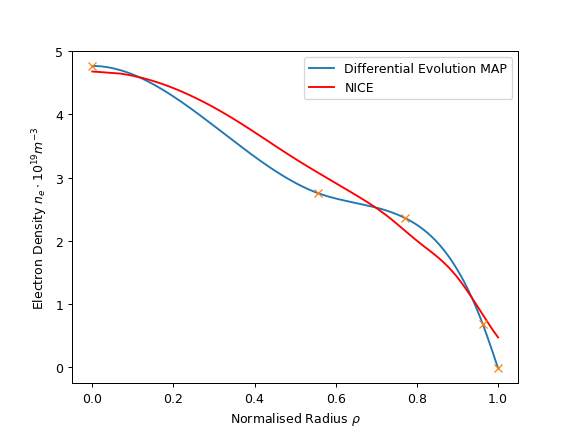

In [93]:
hyperparameters['L'] = 0.7
print('Hyper Parameters Are:')
print(hyperparameters)
post_smooth.ComputeMAP(hyperparameters, verbose=True)
a=1

In [94]:
pa_map = post_smooth.params_map

Hyperparameters {'NKNOTS': 5, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 4}
Performing MCMC Sampling of Posterior
Making New Sampler
MCMC sampling starts
Sampling


100%|██████████| 3000/3000 [01:38<00:00, 30.37it/s]

Sampling finished. Time Taken: 98.8348298072815 s
Making Trace Plots to Determine Burn in Period
Walker 1


<IPython.core.display.Javascript object>


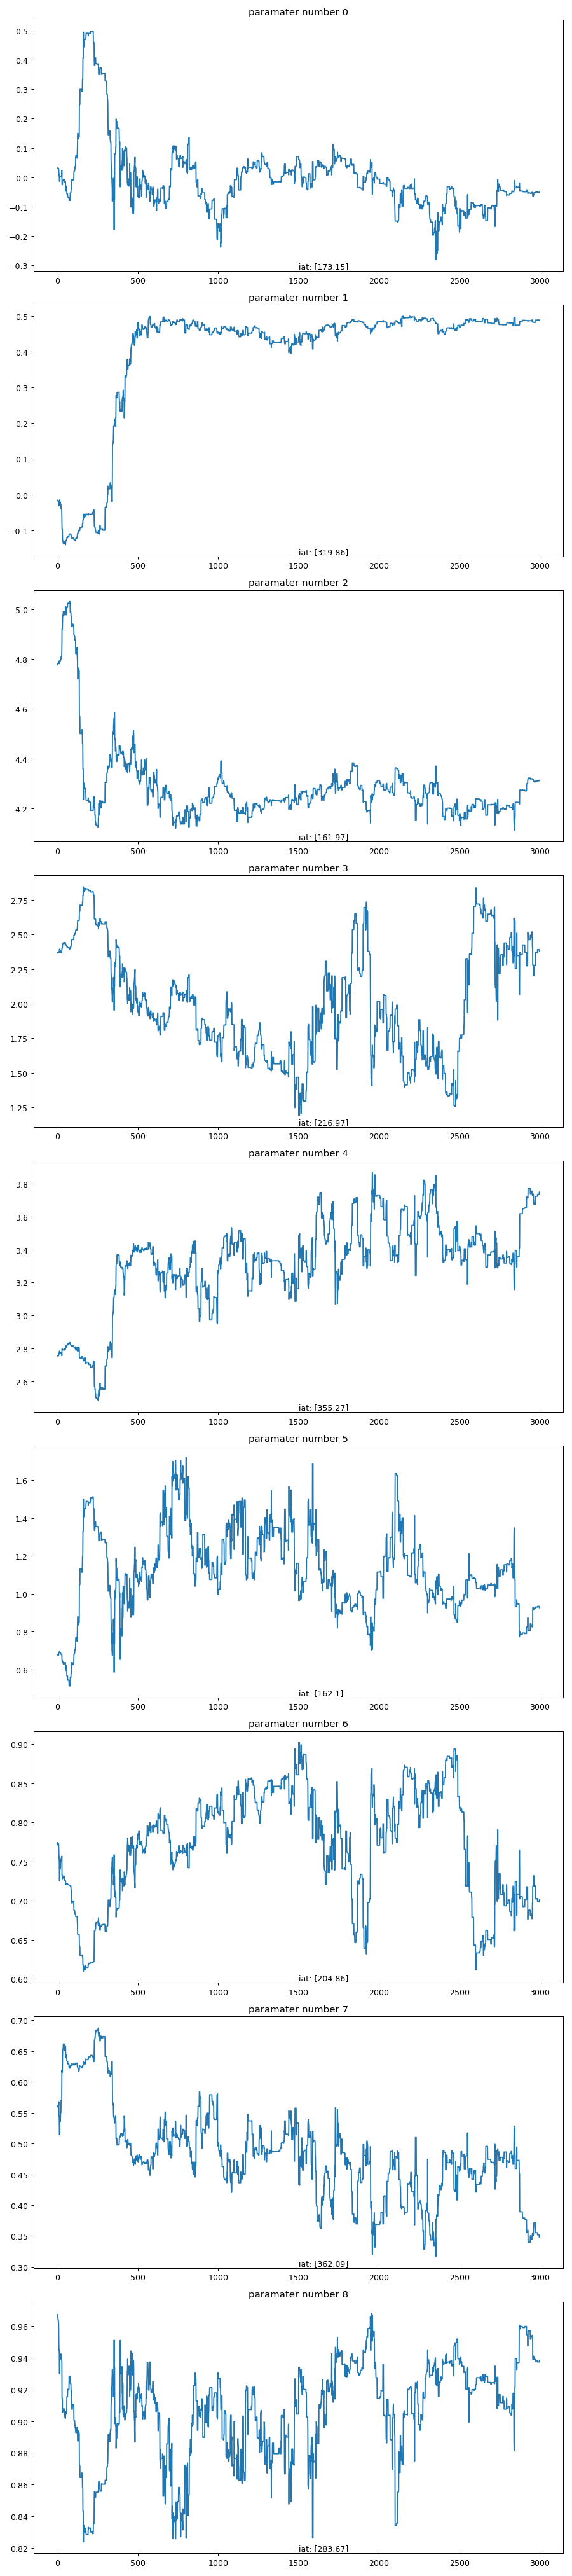

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [173.14953193]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [319.85722224]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [161.97195925]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [216.97270669]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [355.26545496]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with c

<IPython.core.display.Javascript object>


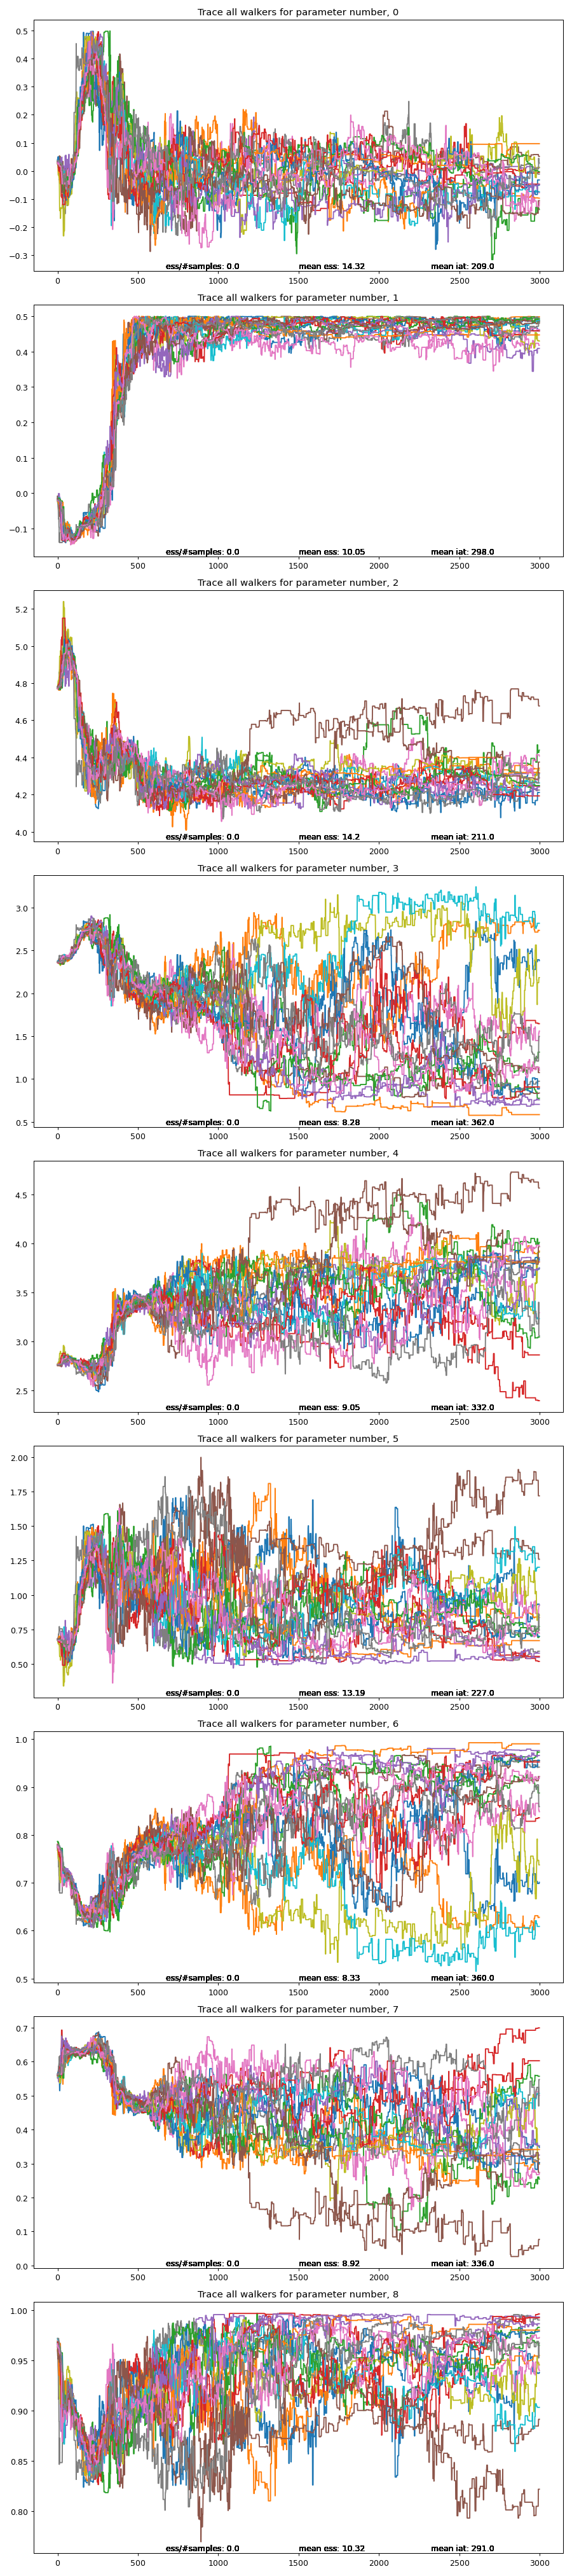

In [119]:
post_smooth.params_map = pa_map
# post_smooth.nburn = 1
post_smooth.nsamples = 3000
print('Hyperparameters',hyperparameters)
post_smooth.MCMCsampling(hyperparameters)
post_smooth.TracePlots(1)
# profile_averages = post_smooth.Plot_posterior(hyperparameters)
a=1                                           

In [ ]:
post_smooth.Plot_posterior(hyperparameters, nburn=1500, thin=5)

/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 25.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Converting the Samples to Profiles


<IPython.core.display.Javascript object>


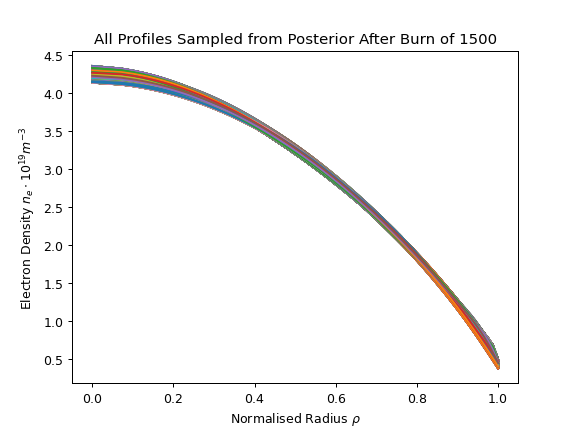

In [116]:
fig100prof = plt.figure()
plt.title('All Profiles Sampled from Posterior After Burn of 1500')
for prof in post_smooth.profiles_sampled[:]:
    plt.plot(RHO, prof)
    
plt.xlabel(r'Normalised Radius $\rho$')
plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$')  
plt.show()


In [118]:
Client.restart(client)

2023-11-20 12:17:14,927 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:14,939 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:14,941 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:14,955 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:14,977 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:14,982 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:14,992 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:14,993 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:15,011 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:15,017 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:15,018 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:15,022 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:15,027 - distributed.nanny - WARNING - Restarting worker
2023-11-20 12:17:15,029 - distributed.

<Client: 'tcp://127.0.0.1:41359' processes=0 threads=0, memory=0 B>

$$R \vec{n_e}$$

In [25]:
post_smooth.nburn = 1
post_smooth.nsamples = 400
# print(hyperparameters)
# hyperparameters = post_smooth.Optimise_hyper('L', hyperparameters, study_name='optimise_l_smooth_5KNOTS2')
# a=1

In [26]:
# post_smooth.ComputeMAP(hyperparameters, verbose=True)

<IPython.core.display.Javascript object>


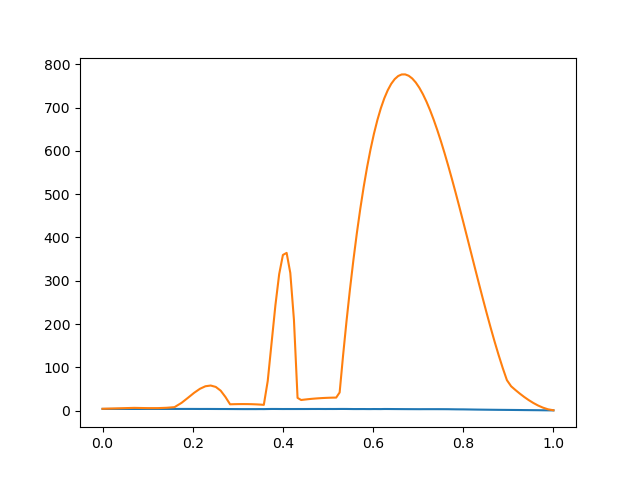

In [61]:
plt.figure()
plt.plot(RHO,profile_averages['median'])
plt.plot(RHO,profile_averages['upper'])
plt.show()

# Trialing Different L Values to find NICE like Profile

To see how close to nice I could get the profile from tuning l I trialed 10 l values from 0.1 to 10.1 and computed the least square error for each with NICE. I then did a finer tuning and took to l with the lowerst least square error and trialed 10 more equally spaced l values within 1 from the previous best. The result was l = 2.2111 has the smallest least square error with NICE, and it looks close too. 


Computing MAP


/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Results of MAP for amp: 50 and l: 0.1 


 message: Optimization terminated successfully.
 success: True
     fun: 110.48936083243451
       x: [-1.345e-02  1.499e-02  4.203e+00  2.499e+00  2.781e+00
            2.487e+00  5.111e-01  6.881e-01  5.120e-01]
     nit: 207
    nfev: 28110
Core Gradient Value: -0.013448770770234486
Edeg Spline Value: 0.014988358799900237
Other Spline Values: [4.20343645 2.49910537 2.78128212 2.48660637 0.51108655 0.68813947
 0.51203359]


/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


<IPython.core.display.Javascript object>


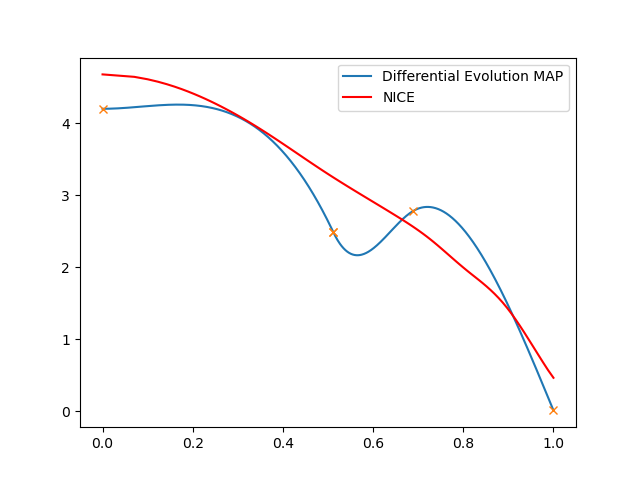

Computing MAP
Results of MAP for amp: 50 and l: 1.1 


 message: Optimization terminated successfully.
 success: True
     fun: 123.80396605105666
       x: [-4.434e-02  2.501e-02  3.072e+00  2.726e+00  3.074e+00
            2.437e+00  7.305e-01  1.671e-04  6.247e-01]
     nit: 458
    nfev: 61995
Core Gradient Value: -0.04434479909683586
Edeg Spline Value: 0.025011101334754038
Other Spline Values: [3.07168470e+00 2.72649531e+00 3.07371312e+00 2.43713351e+00
 7.30531614e-01 1.67122096e-04 6.24662899e-01]


<IPython.core.display.Javascript object>


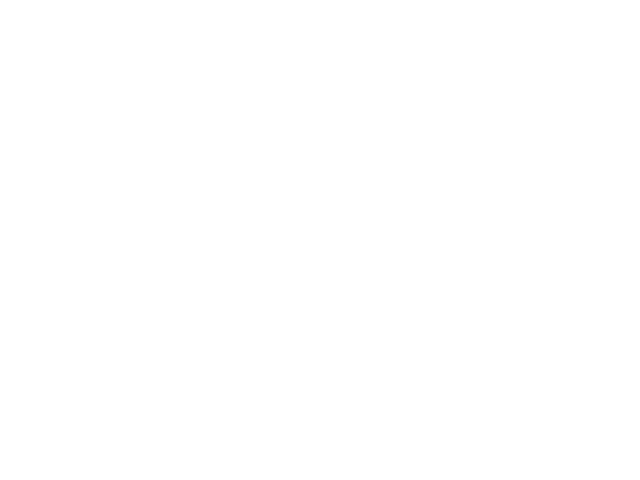

Computing MAP
Results of MAP for amp: 50 and l: 2.1 


 message: Optimization terminated successfully.
 success: True
     fun: 175.42069618259177
       x: [ 1.992e-02  2.312e-01  4.714e+00  2.583e+00  1.070e+00
            2.884e+00  6.874e-01  9.276e-01  5.403e-01]
     nit: 330
    nfev: 44715
Core Gradient Value: 0.019922107668934985
Edeg Spline Value: 0.231209133125991
Other Spline Values: [4.71403416 2.58251495 1.07009727 2.88446955 0.68739204 0.92762522
 0.54029691]


<IPython.core.display.Javascript object>


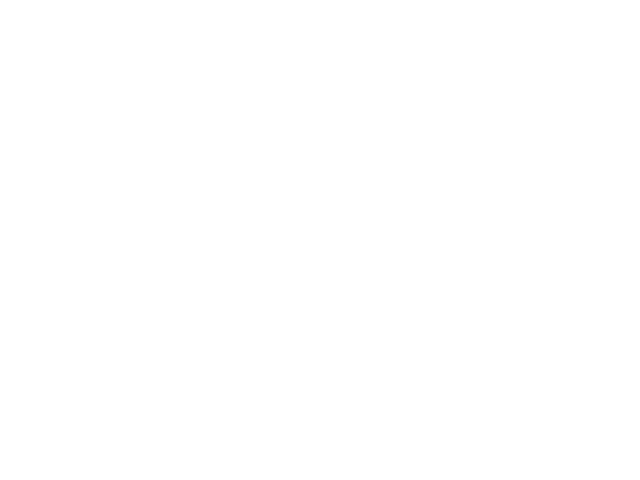

Computing MAP
Results of MAP for amp: 50 and l: 3.1 


 message: Optimization terminated successfully.
 success: True
     fun: 125.25804770046088
       x: [ 1.785e-02  1.345e-03  4.679e+00  3.286e-03  2.802e+00
            2.820e+00  9.999e-01  5.060e-01  5.030e-01]
     nit: 465
    nfev: 62940
Core Gradient Value: 0.017850484128139055
Edeg Spline Value: 0.001344956185771129
Other Spline Values: [4.67931277e+00 3.28616210e-03 2.80249460e+00 2.82023708e+00
 9.99914986e-01 5.05990957e-01 5.03041985e-01]


<IPython.core.display.Javascript object>


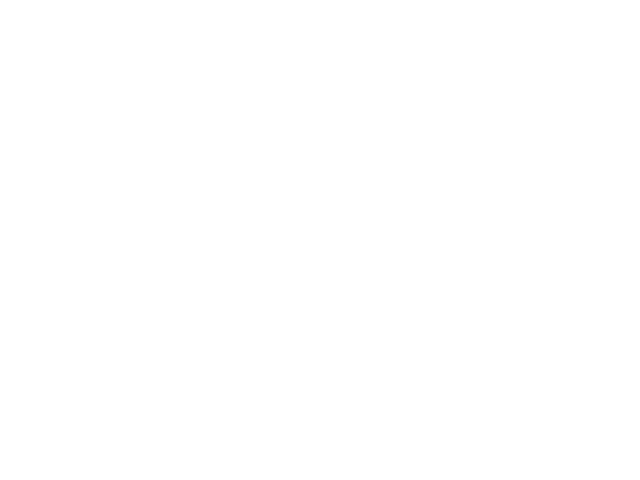

Computing MAP
Results of MAP for amp: 50 and l: 4.1 


 message: Optimization terminated successfully.
 success: True
     fun: 126.06375608631677
       x: [-1.352e-02 -3.354e-04  4.683e+00  3.046e+00  3.331e-03
            2.680e+00  4.636e-01  9.998e-01  5.411e-01]
     nit: 510
    nfev: 69015
Core Gradient Value: -0.013518900484572882
Edeg Spline Value: -0.00033539589143621873
Other Spline Values: [4.68333337e+00 3.04572949e+00 3.33134520e-03 2.68021926e+00
 4.63634043e-01 9.99834044e-01 5.41101026e-01]


<IPython.core.display.Javascript object>


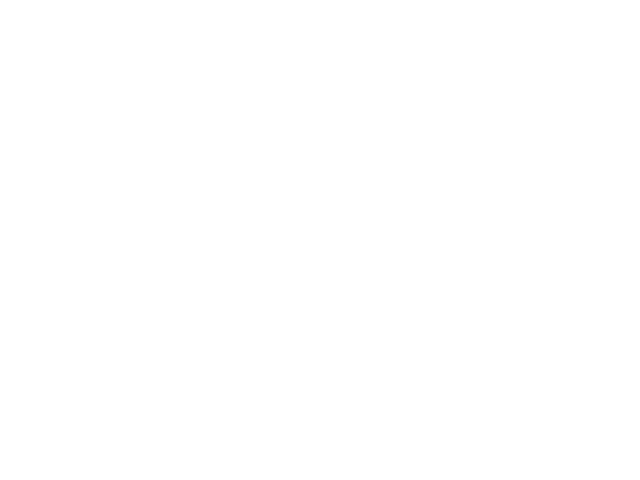

Computing MAP
Results of MAP for amp: 50 and l: 5.1 


 message: Optimization terminated successfully.
 success: True
     fun: 125.7565646583482
       x: [ 9.698e-03 -2.844e-03  4.642e+00  3.114e+00  2.737e+00
            7.614e-04  4.588e-01  5.392e-01  9.998e-01]
     nit: 698
    nfev: 94395
Core Gradient Value: 0.009697673958434017
Edeg Spline Value: -0.0028438958741882625
Other Spline Values: [4.64191569e+00 3.11400351e+00 2.73721655e+00 7.61391060e-04
 4.58768936e-01 5.39166793e-01 9.99828623e-01]


<IPython.core.display.Javascript object>


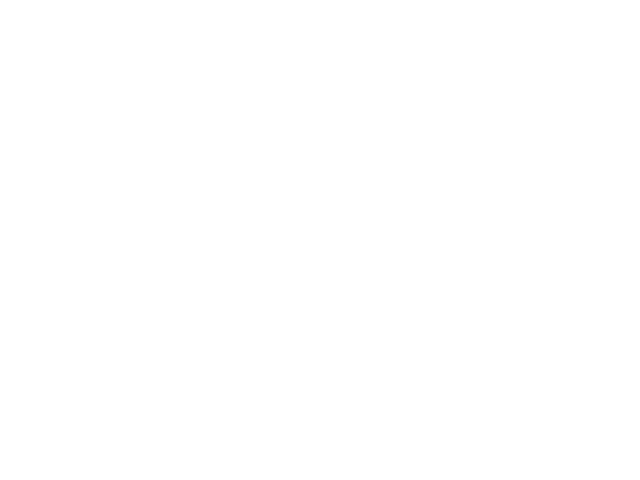

Computing MAP
Results of MAP for amp: 50 and l: 6.1 


 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 120.49361020001963
       x: [-3.882e-02  9.676e-03  4.556e+00  3.044e+00  1.866e-02
            3.054e+00  4.544e-01  9.996e-01  4.531e-01]
     nit: 1000
    nfev: 135165
Core Gradient Value: -0.03882159681799835
Edeg Spline Value: 0.009676071974330736
Other Spline Values: [4.55556772 3.04386836 0.01866337 3.05413997 0.45440863 0.99959209
 0.45314336]


<IPython.core.display.Javascript object>


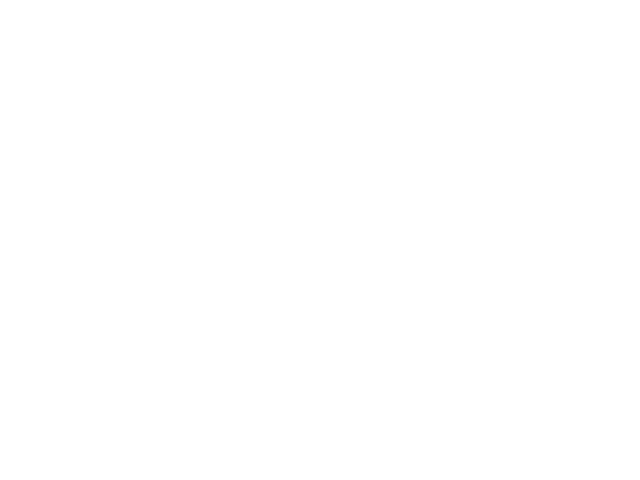

Computing MAP
Results of MAP for amp: 50 and l: 7.1 


 message: Optimization terminated successfully.
 success: True
     fun: 87.99959348777449
       x: [-3.086e-02 -1.993e-02  4.257e+00  1.742e+00  1.809e+00
            1.738e+00  5.957e-01  5.795e-01  5.955e-01]
     nit: 601
    nfev: 81300
Core Gradient Value: -0.030863052707310323
Edeg Spline Value: -0.019933765313623786
Other Spline Values: [4.2573159  1.74231718 1.8090507  1.73791045 0.59573155 0.57954115
 0.59548347]


<IPython.core.display.Javascript object>


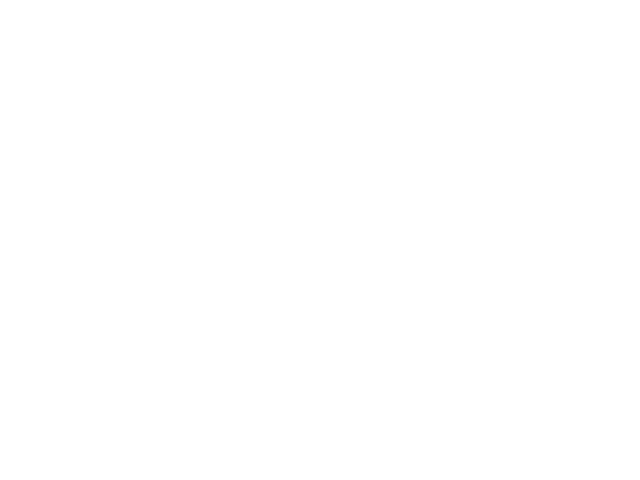

Computing MAP
Results of MAP for amp: 50 and l: 8.1 


 message: Optimization terminated successfully.
 success: True
     fun: 127.75412500376743
       x: [ 4.950e-02  3.125e-03  4.729e+00  2.871e+00  5.086e-03
            2.892e+00  4.888e-01  9.999e-01  4.851e-01]
     nit: 953
    nfev: 128820
Core Gradient Value: 0.0494950750071399
Edeg Spline Value: 0.003125241150979563
Other Spline Values: [4.72904618 2.87105522 0.00508613 2.89225992 0.48879206 0.99990929
 0.48507109]


<IPython.core.display.Javascript object>


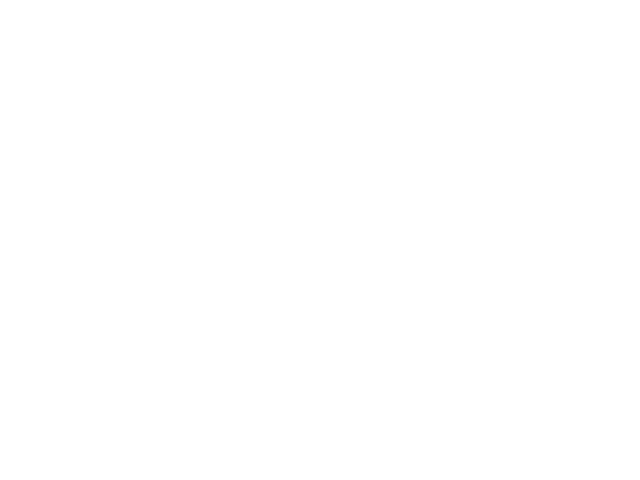

Computing MAP
Results of MAP for amp: 50 and l: 9.1 


 message: Optimization terminated successfully.
 success: True
     fun: 213.24176174615388
       x: [-4.129e-02  4.918e-01  6.010e+00  2.500e+00  5.970e+00
            5.960e+00  7.011e-01  1.108e-02  1.186e-02]
     nit: 542
    nfev: 73335
Core Gradient Value: -0.041291498740757326
Edeg Spline Value: 0.49178383914264157
Other Spline Values: [6.01043608 2.5003661  5.96990298 5.95965082 0.7010793  0.01108042
 0.01186013]


<IPython.core.display.Javascript object>


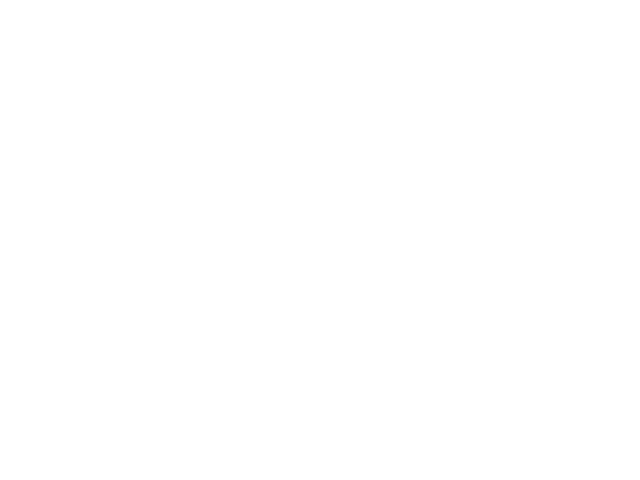

In [8]:
l_trials = np.arange(0.1, 10.1)

lsqe_list = []
profile_list = []
for l in l_trials:
    hyperparameters['L'] = l
    params_map = post_smooth.ComputeMAP(hyperparameters, verbose=True)
    profile = post_smooth.Profile(params_map, nice_rho, hyperparameters)
    lsqe_list.append(np.sum((nice-profile)**2)/len(nice))
    profile_list.append(profile)

In [9]:
#most nice like l
l_nicelike = l_trials[larg]
larg = np.argmin(lsqe_list)
print('NICE like l is', l_nicelike)

NICE like l is 2.1


Computing MAP
Results of MAP for amp: 50 and l: 2.1 


 message: Optimization terminated successfully.
 success: True
     fun: 176.63118276946173
       x: [ 1.024e-02  2.936e-01  4.701e+00  1.335e+00  2.922e+00
            2.321e+00  9.029e-01  5.297e-01  7.562e-01]
     nit: 172
    nfev: 23385
Core Gradient Value: 0.01024023254293327
Edeg Spline Value: 0.29356378329906274
Other Spline Values: [4.70053651 1.33451155 2.92154312 2.32073495 0.90290064 0.52973288
 0.75615687]


<IPython.core.display.Javascript object>


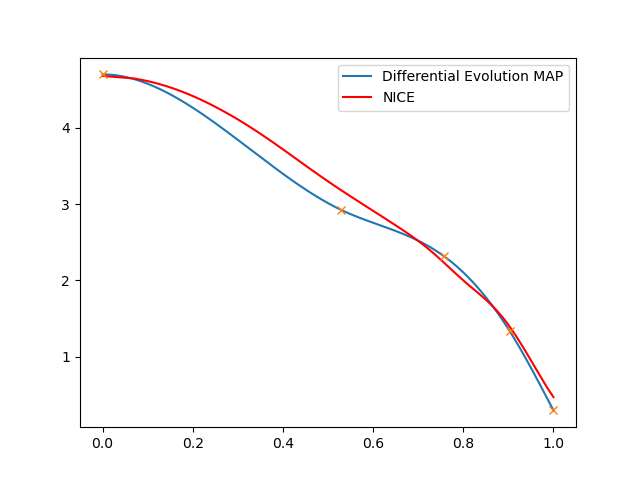

array([0.01024023, 0.29356378, 4.70053651, 1.33451155, 2.92154312,
       2.32073495, 0.90290064, 0.52973288, 0.75615687])

In [10]:
hyperparameters['L'] = l_nicelike
post_smooth.ComputeMAP(hyperparameters, verbose=True)


NICE like l is 2.1
Computing MAP
Results of MAP for amp: 50 and l: 1.1 


 message: Optimization terminated successfully.
 success: True
     fun: 140.4386931062195
       x: [ 5.929e-02  2.694e-02  4.802e+00  1.733e+00  2.556e+00
            2.571e+00  8.821e-01  6.667e-01  6.965e-01]
     nit: 205
    nfev: 27840
Core Gradient Value: 0.059286682151711734
Edeg Spline Value: 0.026939470751511818
Other Spline Values: [4.802017   1.7327099  2.55595411 2.57075998 0.88212234 0.66666308
 0.6965308 ]


<IPython.core.display.Javascript object>


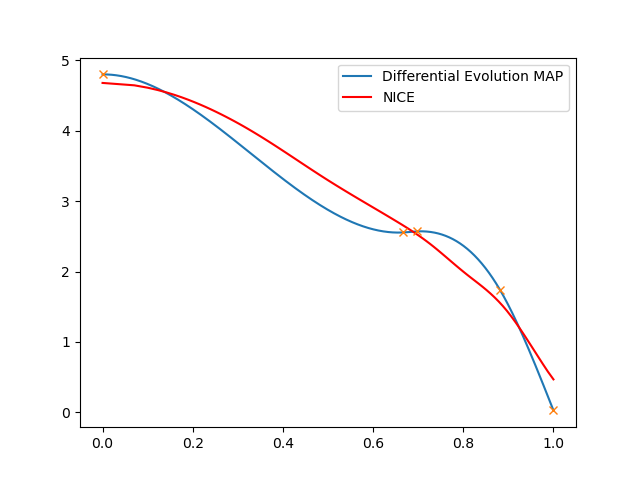

Computing MAP
Results of MAP for amp: 50 and l: 1.3222222222222224 


 message: Optimization terminated successfully.
 success: True
     fun: 143.13694663633424
       x: [-1.896e-02  5.084e-02  4.767e+00  9.536e-02  2.644e+00
            2.492e+00  9.976e-01  6.033e-01  7.433e-01]
     nit: 250
    nfev: 33915
Core Gradient Value: -0.01895923316012038
Edeg Spline Value: 0.05084476595903986
Other Spline Values: [4.7665281  0.09535745 2.64417528 2.49227578 0.9975572  0.60328562
 0.74326313]


<IPython.core.display.Javascript object>


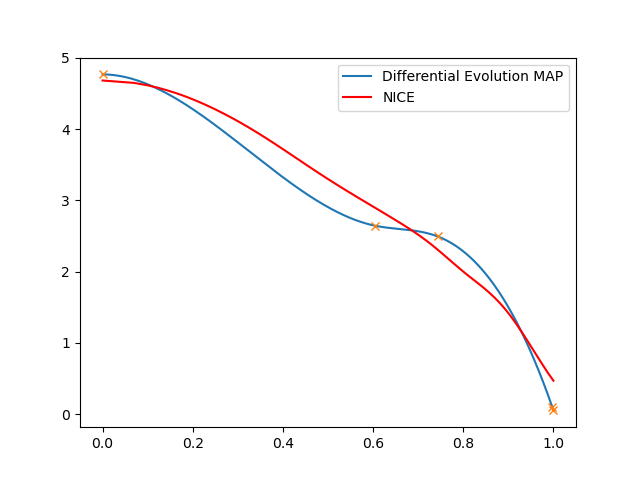

Computing MAP
Results of MAP for amp: 50 and l: 1.5444444444444445 


 message: Optimization terminated successfully.
 success: True
     fun: 148.87042861769868
       x: [ 2.339e-02  4.190e-02  4.799e+00  1.391e+00  2.632e+00
            2.581e+00  9.045e-01  6.192e-01  7.073e-01]
     nit: 315
    nfev: 42690
Core Gradient Value: 0.023388833808698384
Edeg Spline Value: 0.041898643534014623
Other Spline Values: [4.79873639 1.39091585 2.63181101 2.5805257  0.90447926 0.61921421
 0.70725326]


<IPython.core.display.Javascript object>


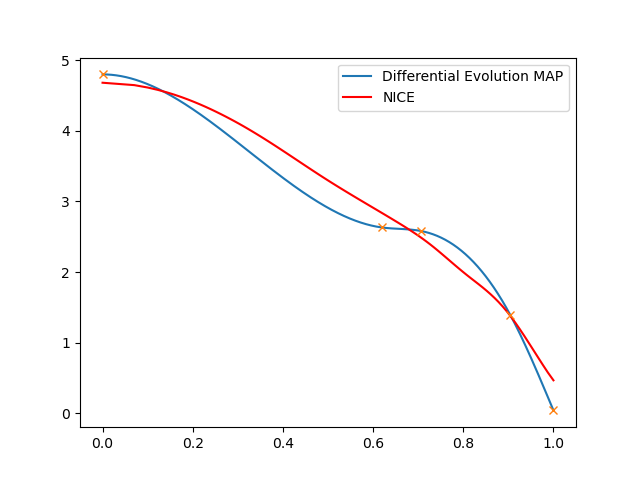

Computing MAP
Results of MAP for amp: 50 and l: 1.7666666666666666 


 message: Optimization terminated successfully.
 success: True
     fun: 95.23605834815449
       x: [-2.219e-02  5.332e-02  4.195e+00  2.141e+00  2.143e+00
            2.610e+00  6.146e-01  6.147e-01  5.140e-01]
     nit: 637
    nfev: 86160
Core Gradient Value: -0.022189468888468566
Edeg Spline Value: 0.05331710625397745
Other Spline Values: [4.19516376 2.14145311 2.14276372 2.60952132 0.61455503 0.61465324
 0.51401055]


<IPython.core.display.Javascript object>


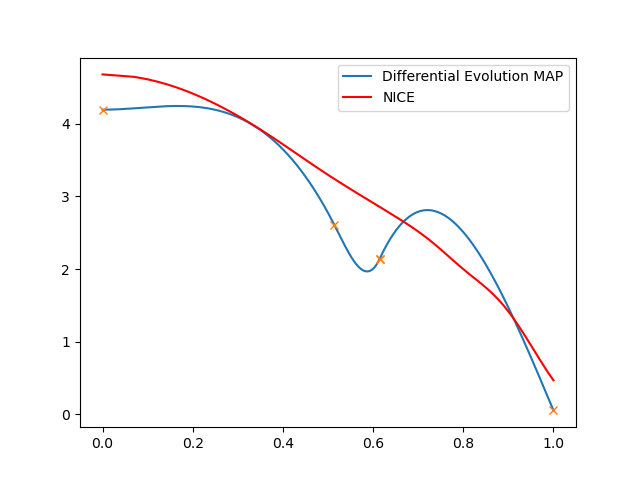

Computing MAP
Results of MAP for amp: 50 and l: 1.988888888888889 


 message: Optimization terminated successfully.
 success: True
     fun: 126.36078896792105
       x: [-2.248e-02  2.503e-04  4.496e+00  3.395e+00  2.733e+00
            2.799e-03  4.064e-01  5.232e-01  9.999e-01]
     nit: 472
    nfev: 63885
Core Gradient Value: -0.022478786195483935
Edeg Spline Value: 0.0002502673313555803
Other Spline Values: [4.49642691e+00 3.39496860e+00 2.73307888e+00 2.79899151e-03
 4.06387064e-01 5.23239442e-01 9.99883178e-01]


<IPython.core.display.Javascript object>


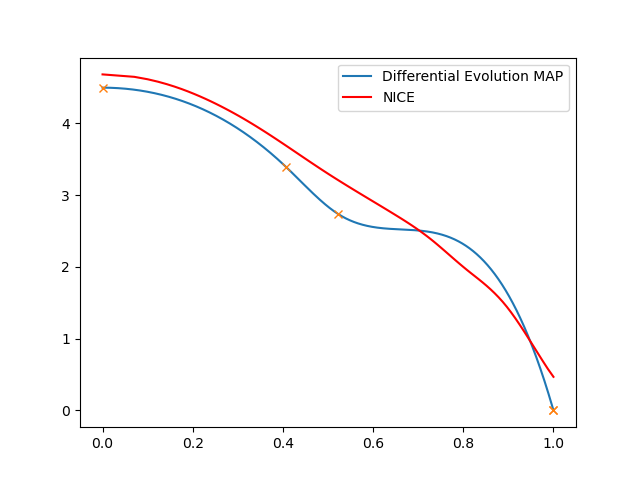

Computing MAP
Results of MAP for amp: 50 and l: 2.2111111111111112 


 message: Optimization terminated successfully.
 success: True
     fun: 182.10624831443994
       x: [ 3.110e-04  2.737e-01  4.681e+00  2.965e+00  1.339e+00
            2.499e+00  5.225e-01  8.991e-01  7.108e-01]
     nit: 198
    nfev: 26895
Core Gradient Value: 0.0003109940831909075
Edeg Spline Value: 0.2737127393519989
Other Spline Values: [4.68074175 2.96501771 1.33942754 2.49928713 0.52247561 0.89913884
 0.71081618]


/tmp/ipykernel_152634/4248933315.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figDifEv = plt.figure()


<IPython.core.display.Javascript object>


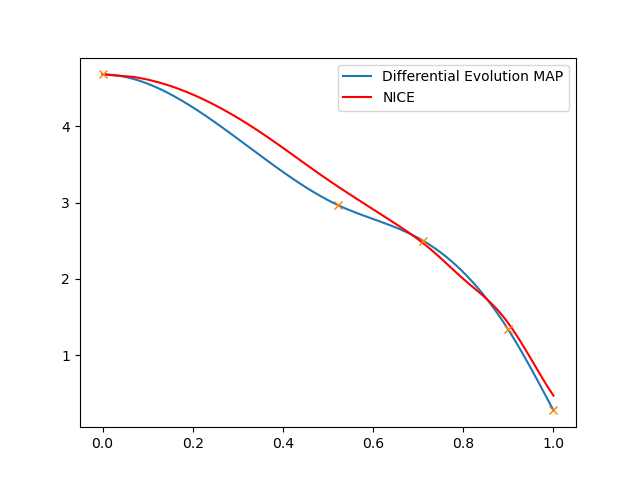

Computing MAP
Results of MAP for amp: 50 and l: 2.4333333333333336 


 message: Optimization terminated successfully.
 success: True
     fun: 93.23505796889714
       x: [ 3.987e-02 -3.854e-03  4.243e+00  2.639e+00  2.157e+00
            2.158e+00  5.121e-01  6.176e-01  6.177e-01]
     nit: 466
    nfev: 63075
Core Gradient Value: 0.039867677672669743
Edeg Spline Value: -0.0038538653452902527
Other Spline Values: [4.24318128 2.63938782 2.15685722 2.1581306  0.5120807  0.61763136
 0.61772704]


<IPython.core.display.Javascript object>


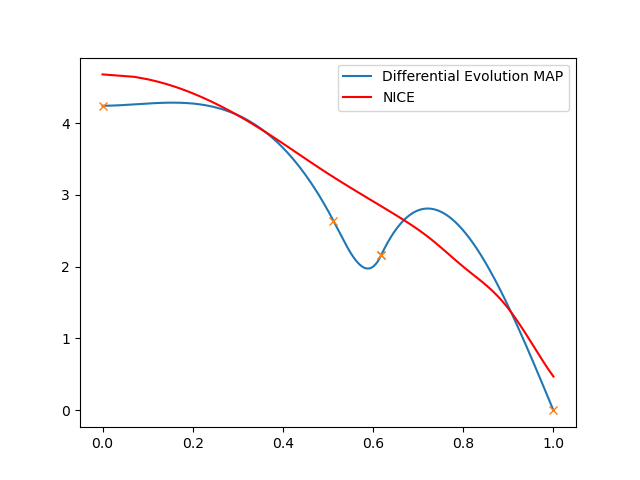

Computing MAP
Results of MAP for amp: 50 and l: 2.6555555555555554 


 message: Optimization terminated successfully.
 success: True
     fun: 93.03605383504244
       x: [-3.327e-02  1.446e-02  4.270e+00  2.182e+00  2.183e+00
            2.594e+00  6.044e-01  6.045e-01  5.128e-01]
     nit: 466
    nfev: 63075
Core Gradient Value: -0.033269569146260614
Edeg Spline Value: 0.014463070622123264
Other Spline Values: [4.26964979 2.18220533 2.18300879 2.59390217 0.60442482 0.60448745
 0.51279976]


<IPython.core.display.Javascript object>


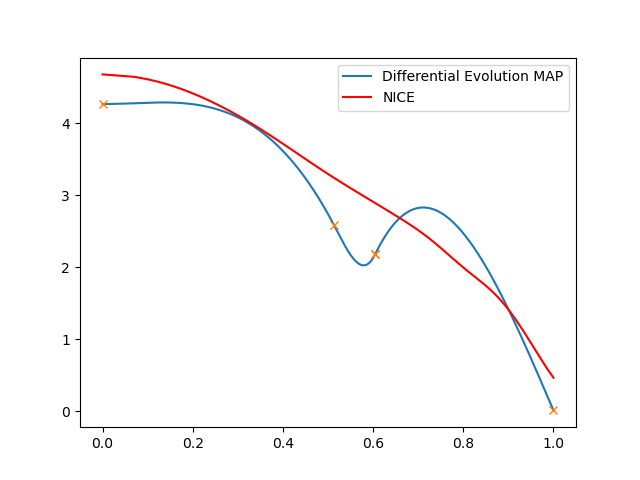

Computing MAP
Results of MAP for amp: 50 and l: 2.8777777777777778 


 message: Optimization terminated successfully.
 success: True
     fun: 91.98224890443485
       x: [-2.691e-02  2.393e-03  4.214e+00  2.070e+00  2.068e+00
            2.487e+00  6.151e-01  6.150e-01  5.235e-01]
     nit: 557
    nfev: 75360
Core Gradient Value: -0.02691431057862076
Edeg Spline Value: 0.0023931738418023762
Other Spline Values: [4.21379938 2.07005285 2.06817484 2.4865385  0.61514547 0.61501852
 0.52353502]


<IPython.core.display.Javascript object>


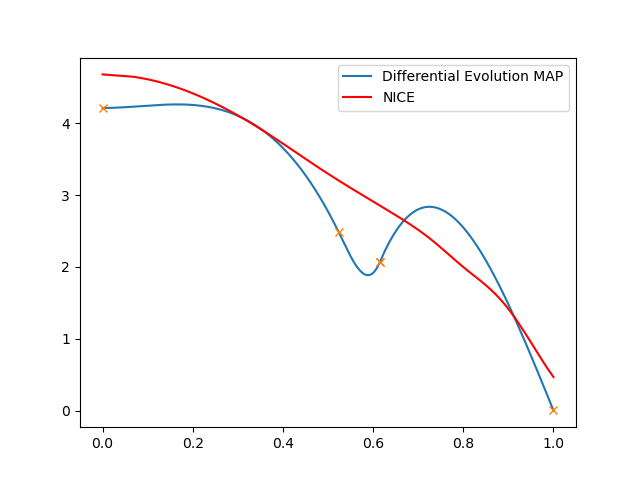

Computing MAP
Results of MAP for amp: 50 and l: 3.1 


 message: Optimization terminated successfully.
 success: True
     fun: 91.96995348889703
       x: [-3.675e-02 -1.076e-02  4.216e+00  2.148e+00  2.647e+00
            2.150e+00  6.170e-01  5.087e-01  6.172e-01]
     nit: 366
    nfev: 49575
Core Gradient Value: -0.036754894260058624
Edeg Spline Value: -0.010758386518259888
Other Spline Values: [4.21555761 2.1481146  2.64696816 2.15017002 0.61701408 0.50874714
 0.61716408]


<IPython.core.display.Javascript object>


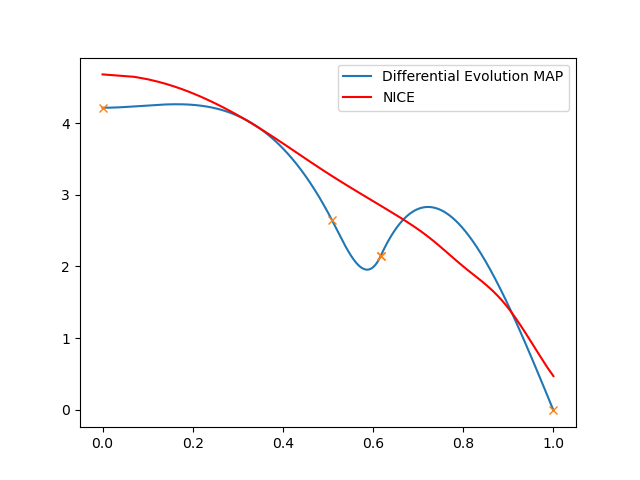

In [11]:
larg = np.argmin(lsqe_list)
l_nicelike = l_trials[larg]
print('NICE like l is', l_nicelike)
l_trials2 = np.linspace(l_nicelike-1, l_nicelike+1,10)

lsqe_list = []
profile_list = []
for l in l_trials2:
    hyperparameters['L'] = l
    params_map = post_smooth.ComputeMAP(hyperparameters, verbose=True)
    profile = post_smooth.Profile(params_map, nice_rho, hyperparameters)
    lsqe_list.append(np.sum((nice-profile)**2)/len(nice))
    profile_list.append(profile)

In [12]:
#most nice like l
larg = np.argmin(lsqe_list)
l_nicelike = l_trials2[larg]
print('NICE like l is', l_nicelike)

NICE like l is 2.2111111111111112


Computing MAP
Results of MAP for amp: 50 and l: 2.2111111111111112 


 message: Optimization terminated successfully.
 success: True
     fun: 181.40885901578406
       x: [-1.590e-02  2.899e-01  4.674e+00  7.177e-01  2.958e+00
            2.576e+00  9.635e-01  5.240e-01  6.905e-01]
     nit: 271
    nfev: 36750
Core Gradient Value: -0.0158959416685987
Edeg Spline Value: 0.2899403170092809
Other Spline Values: [4.674158   0.71769934 2.95752013 2.57556399 0.96352569 0.52401057
 0.69045081]


<IPython.core.display.Javascript object>


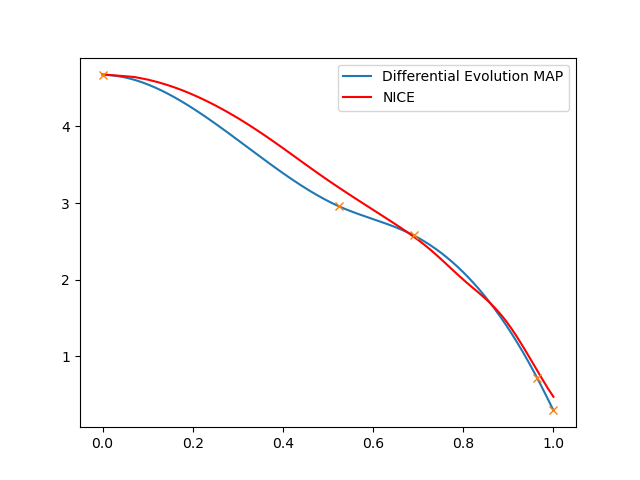

array([-0.01589594,  0.28994032,  4.674158  ,  0.71769934,  2.95752013,
        2.57556399,  0.96352569,  0.52401057,  0.69045081])

In [13]:
hyperparameters['L'] = l_nicelike
post_smooth.ComputeMAP(hyperparameters, verbose=True)


{'NKNOTS': 10, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 2.2111111111111112}
Performing MCMC Sampling of Posterior
MCMC sampling starts
Burn-in


100%|██████████| 500/500 [00:07<00:00, 66.59it/s]


Sampling


100%|██████████| 4000/4000 [00:51<00:00, 77.26it/s]


Sampling finished. Time Taken: 59.32946228981018 s
Converting the Samples to Profiles


100%|██████████| 10284/10284 [00:25<00:00, 407.09it/s]


Time Taken: 85.80952906608582 s
Computing the mean and 95% confidance intervals


<IPython.core.display.Javascript object>


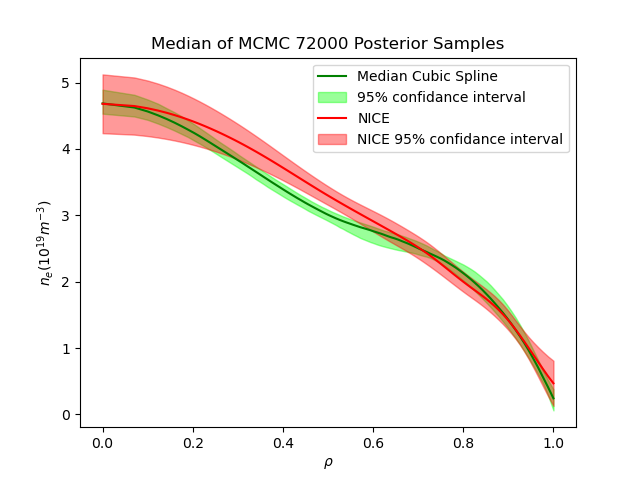

<IPython.core.display.Javascript object>


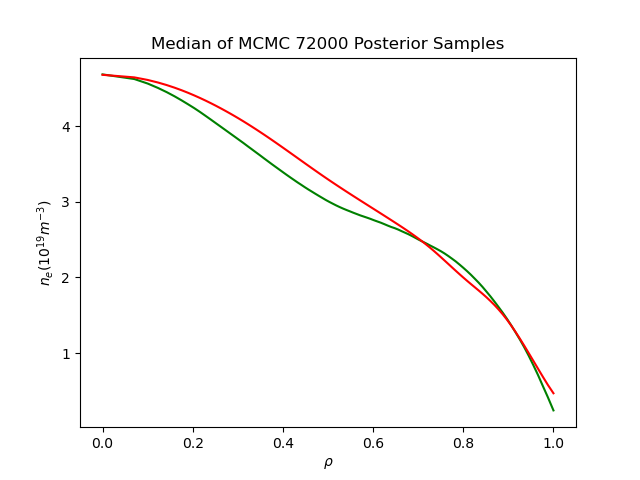

In [14]:
print(hyperparameters)
profile_averages = post_smooth.Plot_posterior(hyperparameters)

<IPython.core.display.Javascript object>


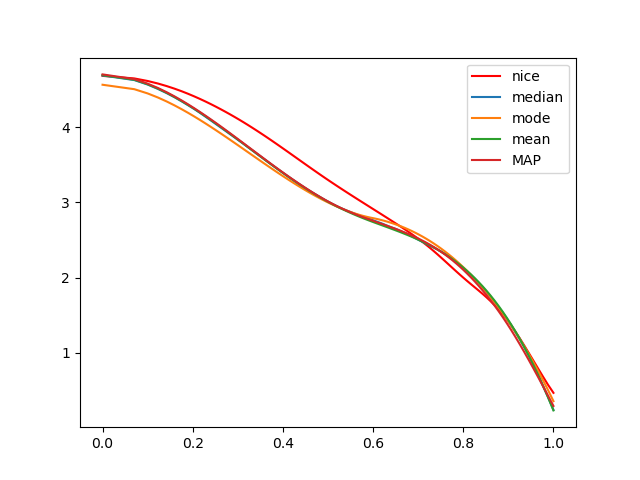

In [19]:
plt.figure()
params_map = np.array([0.01024023, 0.29356378, 4.70053651, 1.33451155, 2.92154312,
               2.32073495, 0.90290064, 0.52973288, 0.75615687])
profile_map = post_smooth.Profile(params_map, RHO, hyperparameters)
plt.plot(nice_rho,nice, 'r', label='nice')
plt.plot(RHO, profile_averages['median'], label='median')
plt.plot(RHO, profile_averages['mode'], label='mode')
plt.plot(RHO, profile_averages['mean'], label='mean')

plt.plot(RHO, profile_map, label='MAP')
plt.legend()
plt.show()

# Equally Spaces Knots

When the knots are close together in $\rho$ and further apart in $n_e$ the cubic spline must have a very large gradient to connect the two. This creates very large dramatic curves that go to extream values. This likely causes the large errors on the MCMC 95% confidance intervals.  
  
To solve this issue the knots will not be equally spaced and not a hyper parameter.

Constants:
Interferometry Data, line integrated density of lasers, $\vec d$  
Edge Knot Location at $\rho=1$  
Core Knot Location at $\rho=0$  

Hyperparameters:
Amplitude, $\sigma$, amp = 50
Lengthscale, $l$ = 4, to be tuned
Number of MCMC Burn Samples, NBURN = 500, lowered to 50, for tuning l
Number of MCMC Sample, NSAMPLES = 4000, lowered to 400, for tuning l
Number of MCMC Walkers = 2*number of cubic spline parameters = 2*19 = 38
Number of Knots, NKNOTS = 5  
Experimental Error, $\sigma_{er}$ = 0.03 (as reported by WEST)   
Standard Deviation of Edge Spline Value, $\sigma_{esv}$ = 0.1   
Standard Deviation of Core Gradient Value, $\sigma_{cgv}$ = 0.1   
Bounds of Knot Locations uniform prior [0,1]  
Bounds of Spline Values uniform prior [0,10]

Cubic Spline Parameters:  
Knot Locations, equally spaced  
Spline Values (except edge), uniform prior  
Edge Spline Value, Gaussian prior  
Core Spline Gradient, Gaussian prior.  

In [8]:
NBURN = 500
NSAMPLES = 4000

# Hyperparamters
NKNOTS = 5
SIGer = 0.03
SIGesv = 0.1
SIGcgv = 0.1
AMP = 50
L = 0.7
#might not be necessary any more since no uniform dist are used
BOUNDS = [(-5*SIGcgv,5*SIGcgv),(-5*SIGesv,5*SIGesv)]+[(0,10) for i in range(NKNOTS-1)]# + [(0,1) for i in range(NKNOTS-2)]
RHO = dens_prof.rho_tor_norm_1d #equilivant of np.linspace(0,1,101) 
rho_1000 = np.linspace(0,1,1000)
#geo is line geometry, equi are the fulxsurfaces equilibrium
R = compute_response_matrix(geo, equi, RHO)
d = interf.lid

hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
hyperbounds = {"NKNOTS":(3,40),"SIGer":(0,0.5),"SIGesv":(0,0.5),"SIGcgv":(0,0.5),'AMP':(0,50),'L':(0,10)}

class PosterioR:
    def __init__(self, hyperbounds, bounds, rho, R, d, nburn, nsamples):
        self.hyperbounds = hyperbounds
        self.bounds = bounds
        self.rho = rho
        self.R = R
        self.d = d
        self.nburn = nburn
        self.nsamples = nsamples
        self.params_map = None
        
        self.profiles_sampled = None

    def Kernel(self, rho1, rho2, hyperparameters):
        amp = hyperparameters['AMP']
        l = hyperparameters['L']
        RHOA, RHOB = np.meshgrid(rho1,rho2)
        return amp**2 * np.exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))
    
    def Profile(self, params, rho, hyperparameters):
        cgv, esv = params[0:2]
        spline_values = params[2:NKNOTS+1]
#         knot_locations = params[NKNOTS+1:]
        all_knots = np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
        all_spline_values = np.block([spline_values,esv])
        #ensure unique to avoid error, x must be increasing
        if len(np.unique(all_knots))<len(all_knots):
            all_knots = all_knots + np.linspace(0,0.000001,len(all_knots))
        sort = np.argsort(all_knots)
        cubic_spline = CubicSpline(all_knots[sort], all_spline_values[sort], bc_type=((1,cgv),(2,0)))
        n_e = cubic_spline(rho)
        return n_e
    def Plot_profile(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        fig_prof = plt.figure()
        plt.plot(self.rho, n_e)
        plt.xlabel(r'Normalised Radius $\rho$')
        plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$')   
        plt.show()
    
    def Log_prior(self, params, hyperparameters):
            #check bounds
        within_bounds = True
        for i in range(len(params)):
            within_bounds = within_bounds and params[i] > self.bounds[i][0] and params[i] < self.bounds[i][1]
        if not within_bounds:
            return -np.inf    
        cgv, esv = params[0:2]
        spline_values = params[2:NKNOTS+1]
#         knot_locations = params[NKNOTS+1:]
        all_knots = np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
        all_spline_values = np.block([spline_values,esv])
        
#         K = self.Kernel(all_knots,all_knots, hyperparameters) + np.diag(np.repeat(1e-5,NKNOTS))
#         prior_spline_values = mvn(mean=np.zeros(NKNOTS), cov=K)
        
        ne = self.Profile(params, self.rho, hyperparameters)
        K = self.Kernel(self.rho,self.rho, hyperparameters) + np.diag(np.repeat(1e-3,len(self.rho)))
        prior_ne = mvn(mean=np.zeros(len(self.rho)), cov=K)
        return -(esv**2 / hyperparameters['SIGesv']**2) - (cgv**2 /  hyperparameters['SIGcgv']**2) + prior_ne.logpdf(x=ne)

    def Log_likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        LID = R @ n_e
        return np.sum(-(self.d - LID)**2 / hyperparameters['SIGer']**2)
    
    def Log_posterior(self, params,NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return -np.inf
        else:
            return log_prior + self.Log_likelihood(params, hyperparameters)

    def Neg_log_posterior(self, params,NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
        hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        log_prior = self.Log_prior(params, hyperparameters)
        if not np.isfinite(log_prior):
            return np.inf
        else:
            return -(log_prior + self.Log_likelihood(params, hyperparameters))
    
    def ComputeMAP(self, hyperparameters, verbose=False):
        print('Computing MAP')
        results = differential_evolution(self.Neg_log_posterior, self.bounds, workers=nworkers, args=tuple(hyperparameters.values()), maxiter=5000)
        self.params_map = results.x
        if verbose:
            print('Results of MAP for amp:',hyperparameters['AMP'],'and l:',hyperparameters['L'],'\n\n')
            print(results)
            print('Core Gradient Value:',results.x[0])
            print('Edeg Spline Value:',results.x[1])
            print('Other Spline Values:',results.x[2:])
            
            rho_1000 = np.linspace(0,1,1000)
            params_map=results.x
            cgv, esv = params_map[0:2]
            spline_values = params_map[2:NKNOTS+1]
            #knot_locations = params_map[NKNOTS+1:]
            all_knots = np.linspace(0,1,hyperparameters['NKNOTS'])#np.block([np.zeros(1), knot_locations, np.ones(1)])
            all_spline_values = np.block([spline_values,esv])
        
            figDifEv = plt.figure()
            plt.plot(rho_1000,self.Profile(results.x, rho_1000, hyperparameters),label='Differential Evolution MAP')
            plt.plot(RHO,nice, 'r', label='NICE')
            plt.plot(all_knots,all_spline_values,'x')
            plt.legend()
            plt.show()
        return self.params_map
    
    def MCMCsampling(self, hyperparameters, recompute_map=False):
        print('Performing MCMC Sampling of Posterior')
        ndim = len(self.bounds)
        nwalkers = ndim * 2
        if recompute_map:
            self.params_map = self.ComputeMAP(hyperparameters)
        params_start = self.params_map + randgen.uniform(0,0.01,(nwalkers, ndim))
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.Log_posterior, kwargs=(hyperparameters))
        print("MCMC sampling starts")
        time1 = time.time()
        print("Burn-in")
        state = sampler.run_mcmc(params_start, self.nburn, progress=True)
        sampler.reset()
        print('Sampling')
        sampler.run_mcmc(state, self.nsamples, progress=True, skip_initial_state_check=False)
        time2 = time.time()
        samples = sampler.get_chain(flat=True)
        print(f'Sampling finished. Time Taken: {time2 - time1} s')
        return samples
    
    def Likelihood(self, params, hyperparameters):
        n_e = self.Profile(params, self.rho, hyperparameters)
        li = mvn(mean=self.R @ n_e, cov=np.diag(np.repeat(hyperparameters['SIGer'],len(d))))
        return li.pdf(self.d)
    
    def Log_marginal_likelihood(self, samples, hyperparameters):
        #maximizing the marginal likelihood is usefull for paramater optimisation
        #It will be estimates with Harmonic Mean Estimator, 
        #this is the inverse average of the likelihood with posterior samples 
        samples_7split = [samples[a:a+int(samples.shape[0]/nworkers),:] for a in range(nworkers)]
        print('Computing Likelihoods:')
        @dask.delayed
        def li_batch_compute(samples):      
            li = self.Likelihood(samples[0], hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                li = np.block([li, self.Likelihood(samples[i,:],hyperparameters)])
            return li
    
        li_batches = []
        for samples_batch in samples_7split:
            li_batches.append(li_batch_compute(samples_batch))

        li_batches = dask.compute(*li_batches)
        log_marginal_likelihood = -np.log(len(samples) + np.log(np.sum([np.sum(1/li) for li in li_batches])))
        return log_marginal_likelihood
                                          
    def Neglogmargeli(self, hyperparameters):#NKNOTS,SIGer,SIGesv,SIGcgv,AMP,L):
#             print('Trial Value',hyper_value)
#         hyperparameters = {"NKNOTS":NKNOTS,"SIGer":SIGer,"SIGesv":SIGesv,"SIGcgv":SIGcgv,'AMP':AMP,'L':L}
        samples = self.MCMCsampling(hyperparameters, recompute_map=True)
        return -self.Log_marginal_likelihood(samples, hyperparameters)
      
    def Optimise_hyper(self, hyper, hyperparameters, study_name, verbose=False):
        print('\n\nOptimising the hyperparameter:',hyper)
        
        def objective(trial):
            hyper_value = trial.suggest_float(hyper, self.hyperbounds[hyper][0], self.hyperbounds[hyper][1])
            hyperparameters[hyper] = hyper_value
            return self.Neglogmargeli(hyperparameters)
        storage_name = "sqlite:///{}.db".format(study_name)
        study = optuna.create_study(study_name=study_name, storage=storage_name)
        study.optimize(objective, n_trials=500)
        if verbose:
            print('Results of Optimise for ',hyper,' are:', study.best_params[hyper])
        hyperparameters[hyper] = study.best_params[hyper]
        return hyperparameters
        
    def Plot_posterior(self, hyperparameters):
        time_s = time.time()
        @dask.delayed
        def samples2profiles(samples):
            profiles = self.Profile(samples[0,:], self.rho, hyperparameters)
            prog_bar = tqdm(range(1,samples.shape[0])) 
            for i in prog_bar:
                profiles = np.block([[profiles],
                                     [self.Profile(samples[i,:], self.rho, hyperparameters)]])
            return profiles
        
        samples = self.MCMCsampling(hyperparameters)
        samples_7 = [samples[a:a+int(samples.shape[0]/nworkers),:] for a in range(nworkers)]
        print('Converting the Samples to Profiles')
        profiles_batches = []
        for samples_batch in samples_7:
            profiles_batches.append(samples2profiles(samples_batch))
        profiles_batches = dask.compute(*profiles_batches)
        profiles = profiles_batches[0]
        for i in range(1,len(profiles_batches)):
            profiles = np.block([[profiles],
                                 [profiles_batches[i]]])
        print('Time Taken:', time.time() - time_s,'s')
        
        print('Computing the mean and 95% confidance intervals')
        self.profiles_sampled = profiles
        profiles_mean = profiles.mean(axis=0)
        profiles_median = np.median(profiles, axis=0)
        profiles_mode = stats.mode(profiles, axis=0, keepdims=False).mode.flatten()
        profiles_lower = np.percentile(profiles, 2.5, axis=0)
        profiles_upper = np.percentile(profiles, 97.5, axis=0)
        figMCMC = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.fill_between(self.rho, profiles_lower, profiles_upper,color = (0,1,0,0.4),label='95% confidance interval')
        plt.plot(nice_rho, nice, 'r', label='NICE')
        plt.fill_between(nice_rho, nice_lower, nice_upper, color = (1,0,0,0.4), label='NICE 95% confidance interval')
        plt.legend()
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        figMedain = plt.figure()
        plt.title('Median of MCMC '+str(len(samples))+' Posterior Samples')
        plt.plot(self.rho, profiles_median, 'g', label='Median Cubic Spline')
        plt.plot(nice_rho,nice, 'r', label='NICE')  
        plt.plot(self.rho, self.Profile(self.params_map, self.rho, hyperparameters),label='MAP')
        plt.legend()
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$n_e (10^{19} m^{-3})$')
        plt.show()
        return {'mean':profiles_mean,'median':profiles_median,'mode':profiles_mode,'lower':profiles_lower,'upper':profiles_upper}
  
                                     
post_equiknots = PosterioR(hyperbounds, BOUNDS, RHO, R, d, NBURN, NSAMPLES)

In [9]:
print('Hyper Parameters Are:')
print(hyperparameters)
post_equiknots.ComputeMAP(hyperparameters, verbose=True)
a=1

Hyper Parameters Are:
{'NKNOTS': 5, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 0.7}
Computing MAP
Results of MAP for amp: 50 and l: 0.7 


 message: Optimization terminated successfully.
 success: True
     fun: -42.77462713970513
       x: [ 3.511e-03  2.983e-01  4.950e+00  3.980e+00  3.008e+00
            2.417e+00]
     nit: 38
    nfev: 3531
Core Gradient Value: 0.003510877888802666
Edeg Spline Value: 0.29828270733553464
Other Spline Values: [4.94958335 3.97990444 3.00805896 2.4168587 ]


<IPython.core.display.Javascript object>

In [21]:
# post_equiknots.nburn = 10
# post_equiknots.nsamples = 200
study_name = 'profileprior2'
study = optuna.load_study(study_name,f"sqlite:///{study_name}.db")
# hyperparameters = study.best_params()
df = study.trials_dataframe()
# print('Hyperparameters',hyperparameters)
# hyperparameters = post_equiknots.Optimise_hyper('L', hyperparameters, study_name='profileprior')
a=1
df

/tmp/ipykernel_57790/2487180869.py:4: FutureWarning: load_study(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.
  study = optuna.load_study(study_name,f"sqlite:///{study_name}.db")


number value             datetime_start          datetime_complete  \
0       0  None 2023-11-19 22:25:39.390072 2023-11-20 08:07:23.246078   

                duration  params_L state  
0 0 days 09:41:43.856006  9.723422  FAIL

Hyperparameters
{'NKNOTS': 5, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 0.7}
Computing MAP


/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Results of MAP for amp: 50 and l: 0.7 


 message: Optimization terminated successfully.
 success: True
     fun: -42.74975613687619
       x: [ 2.096e-02  2.784e-01  4.954e+00  3.988e+00  3.001e+00
            2.420e+00]
     nit: 43
    nfev: 3981
Core Gradient Value: 0.020964657961315747
Edeg Spline Value: 0.27843255083597673
Other Spline Values: [4.95408429 3.98779686 3.00138047 2.42001531]


/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


<IPython.core.display.Javascript object>


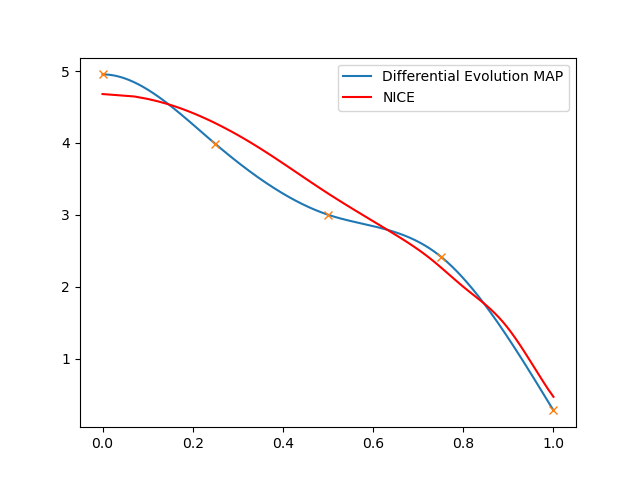

In [9]:
print('Hyperparameters')
hyperparameters['L'] = 0.7
print(hyperparameters)
post_equiknots.ComputeMAP(hyperparameters, verbose=True)
a=1

{'NKNOTS': 5, 'SIGer': 0.03, 'SIGesv': 0.1, 'SIGcgv': 0.1, 'AMP': 50, 'L': 0.7}
Performing MCMC Sampling of Posterior
MCMC sampling starts
Burn-in


100%|██████████| 500/500 [00:11<00:00, 43.72it/s]


Sampling


100%|██████████| 4000/4000 [01:27<00:00, 45.66it/s]


Sampling finished. Time Taken: 99.08222317695618 s
Converting the Samples to Profiles


2023-11-19 22:00:25,824 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 199.16 MiB -- Worker memory limit: 279.75 MiB
  0%|          | 0/3427 [00:00<?, ?it/s]2023-11-19 22:00:25,855 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 201.41 MiB -- Worker memory limit: 279.75 MiB
2023-11-19 22:00:25,856 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-re

Time Taken: 105.88876295089722 s
Computing the mean and 95% confidance intervals


<IPython.core.display.Javascript object>


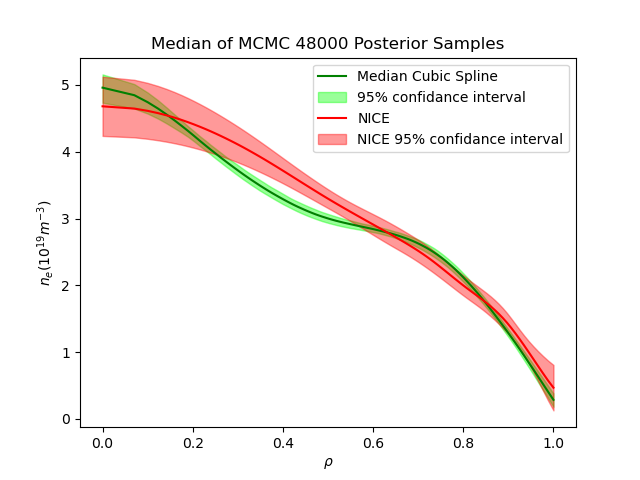

<IPython.core.display.Javascript object>


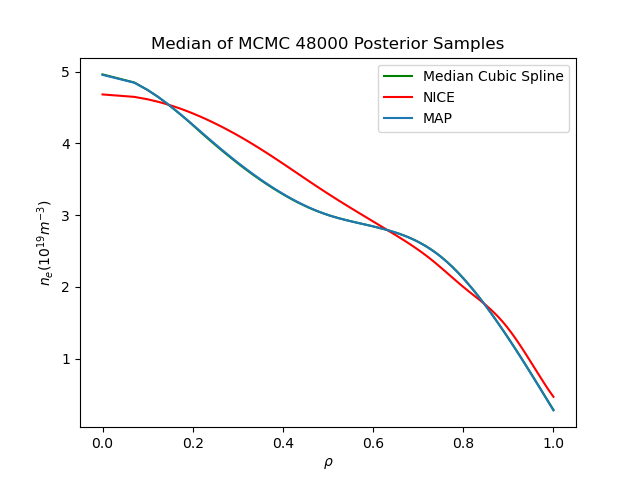

In [10]:
hyperparameters['L'] = 0.7#0.7210554463411043
post_equiknots.nburn = 500
post_equiknots.nsamples = 4000
print(hyperparameters)
profile_averages = post_equiknots.Plot_posterior(hyperparameters)
a=1                                           

<IPython.core.display.Javascript object>


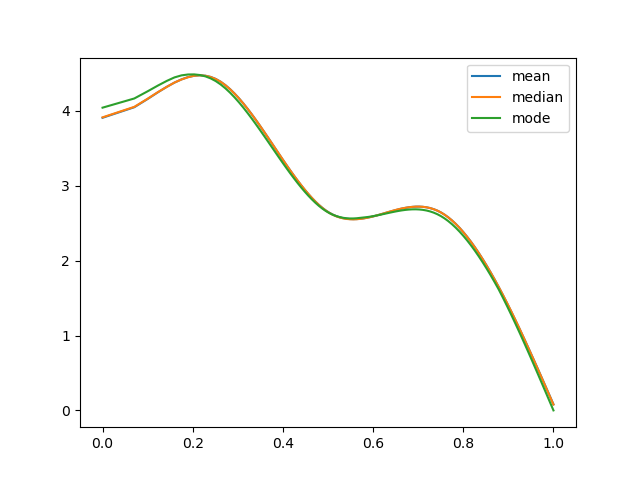

In [14]:
fig = plt.figure()
plt.plot(RHO,profile_averages['mean'],label='mean')
plt.plot(RHO,profile_averages['median'],label='median')
plt.plot(RHO,profile_averages['mode'],label='mode')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


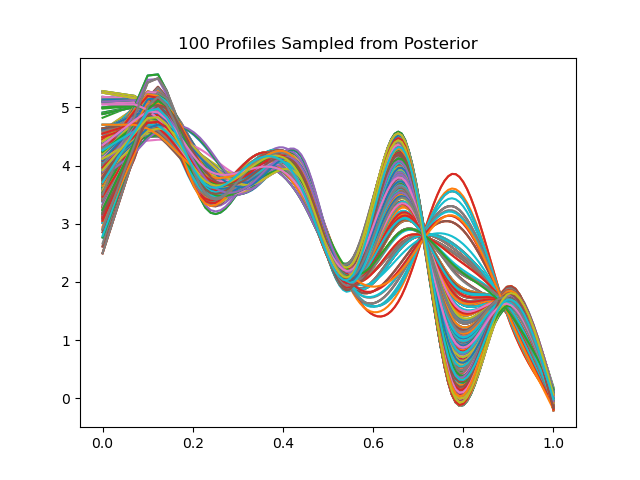

In [20]:
# Other Interesting Graphs

# Plotting 100 MCMC samples

fig100prof = plt.figure()
plt.title('100 Profiles Sampled from Posterior')
for prof in post.profiles_sampled[-1000:]:
    plt.plot(RHO, prof)
plt.show()


In [ ]:
# RHO = dens_prof.rho_tor_norm_1d #equilivant of np.linspace(0,1,101) 

# #geo is line geometry, equi are the fulxsurfaces equilibrium
# R = compute_response_matrix(geo, equi, RHO)
# SPLINE_VAL_UPPER = 10
# d = interf.lid

# # Hyperparamters
# NKNOTS = 6
# SIGer = 0.03
# SIGesv = 0.1
# SIGcgv = 0.1

# BOUNDS = [(-5*SIGcgv,5*SIGcgv),(-5*SIGesv,5*SIGesv)]+[(0,1) for i in range(NKNOTS-2)]+[(0,10) for i in range(NKNOTS-1)]

# def Gen_init_params():
#     initial_cgv = randgen.normal(0,SIGcgv)
#     initial_esv = randgen.normal(0,SIGesv)
#     initial_knot_locations = randgen.uniform(0,1,NKNOTS-2)
#     initial_spline_values = randgen.uniform(0,SPLINE_VAL_UPPER,NKNOTS-1)

#     #Core Gradient Value, Edge Spline Value, Knot Locations, Spline Values
#     initial_params = np.array([initial_cgv,initial_esv]+list(initial_knot_locations)+list(initial_spline_values))
#     return initial_params

# initial_params = Gen_init_params()
    
# def Profile(params):
#     cgv, esv = params[0:2]
#     knot_locations, spline_values = params[2:2+NKNOTS-2], params[2+NKNOTS-2:]
#     all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])
#     all_spline_values = np.block([spline_values,esv])
    
#     #ensure unique to avoid error, x must be increasing
#     if len(np.unique(all_knots))<len(all_knots):
#         all_knots = all_knots + np.linspace(0,0.00001,len(all_knots))
#     sort = np.argsort(all_knots)
# #     print(len(knots))
# #     print(sort)
# #     print(len(np.block([spline_values[sort],esv])))
# #     print(cgv)
#     cubic_spline = CubicSpline(all_knots[sort], all_spline_values[sort], bc_type=((1,cgv),(2,0)))
#     n_e = cubic_spline(RHO)
#     return n_e

# def Log_prior(params):
#     cgv, esv = params[0:2]
#     #check bounds
#     within_bounds = True
#     for i in range(len(params)):
#         within_bounds = within_bounds and params[i] > BOUNDS[i][0] and params[i] < BOUNDS[i][1]
#     if not within_bounds:
#         return -np.inf    
#     return -(esv**2 / SIGesv**2) - (cgv**2 / SIGcgv**2)

# def Log_likelihood(params):
#     n_e = Profile(params)
#     LID = R @ n_e
#     return np.sum(-(d - LID)**2 / SIGer**2)

# def Log_posterior(params):
#     log_prior = Log_prior(params)
#     #
#     if not np.isfinite(log_prior):
#             return +np.inf
#     else:
#             return -log_prior + Log_likelihood(params)

# neg_log_post = lambda x: -Log_posterior(x)
# # map with differential evolution
# results = differential_evolution(Log_posterior, BOUNDS, workers=7)
# # results = minimize(neg_log_post,initial_params)
# # print(results)

In [ ]:
# params_map=results.x
# cgv, esv = params_map[0:2]
# knot_locations, spline_values = params_map[2:2+NKNOTS-2], params_map[2+NKNOTS-2:]
# all_knots = np.block([np.zeros(1), knot_locations, np.ones(1)])
# all_spline_values = np.block([spline_values,esv])

# figDifEv = plt.figure()
# plt.plot(RHO,Profile(results.x),label='Differential Evolution MAP')
# plt.plot(RHO,nice, 'r', label='NICE')
# plt.plot(all_knots,all_spline_values,'.')
# plt.legend()

In [ ]:
# import emcee
# import time
# from scipy import stats
# from tqdm import tqdm

# NBURN = 2000
# NSAMPLES = 2000

# # def samples2profiles(samples):
# #     profiles = Profile(samples[0,:])
# #     prog_bar = tqdm(range(1,samples.shape[0])) 
# #     for i in prog_bar:
# #         profiles = np.block([[profiles],
# #                              [Profile(samples[i,:])]])
# #     return profiles
# # # mcmc
# # Sampling

# ndim = len(initial_params)
# nwalkers = ndim * 6

# params_start = initial_params
# # params_start = params_map + 0.01 * np.random.randn(nwalkers, ndim)
# for i in range(nwalkers-1):
#     init_params = Gen_init_params()
#     params_start = np.block([[params_start],
#                              [init_params]])

# print(np.linalg.cond(params_start))
    
